## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [2]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [3]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme, element_text, ggtitle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import lognorm

In [4]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [5]:
data_set = pd.read_feather("../../../Module 5/financials_against_return.feather")

In [6]:
#testing = data_set[data_set["Ticker"] == "AAPL"]
# testing.to_csv("../../../Module 5/financials.csv")

### Assessment

Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [7]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [8]:
data_set.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,Revenue_change_1_years,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304773,1962
1,NDSN,2005-01-31,0.2248,-3.366,10.663,7.700,62.6220,NaN,NaN,-21.145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387846,1962
2,HURC,2005-01-31,0.3782,0.483,-0.400,2.866,11.3030,0.156,0.854,-0.027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543440,1962
3,NRT,2005-01-31,1.0517,NaN,NaN,NaN,4.9015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331322,1962
4,HRL,2005-01-31,0.4880,-12.075,-113.077,83.476,145.2050,NaN,17.084,3.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218482,1962


In [9]:
data_set.shape

(170483, 145)

Create the target:

In [10]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

In [11]:
data_set.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,Revenue_change_2_years,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target
0,A,2005-01-31,0.1695,81.000,-57.000,137.000,2483.0000,5.000,44.000,-5.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.304773,1962,1.0
1,NDSN,2005-01-31,0.2248,-3.366,10.663,7.700,62.6220,NaN,NaN,-21.145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387846,1962,1.0
2,HURC,2005-01-31,0.3782,0.483,-0.400,2.866,11.3030,0.156,0.854,-0.027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.543440,1962,1.0
3,NRT,2005-01-31,1.0517,NaN,NaN,NaN,4.9015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331322,1962,1.0
4,HRL,2005-01-31,0.4880,-12.075,-113.077,83.476,145.2050,NaN,17.084,3.539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218482,1962,1.0


This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [12]:
def get_weighted_performance_of_stocks(df, metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"] * df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset, "diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [13]:
def split_train_test_by_period(data_set, test_execution_date, include_nulls_in_test=False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [14]:
#First let's remove all features containing info related to the target, we need to modify the cols to remove function
# This column have future data, that's why after examining the data we see that they don't have values for the last year (365) or last two years (730)

def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [15]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [16]:
def run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort( data_set['execution_date'].unique() )

This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [17]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2005-06-30T00:00:00.000000000
2005-09-30T00:00:00.000000000
2005-12-30T00:00:00.000000000
2006-03-31T00:00:00.000000000
2006-06-30T00:00:00.000000000


2006-09-30T00:00:00.000000000
2006-12-30T00:00:00.000000000
2007-03-31T00:00:00.000000000
2007-06-30T00:00:00.000000000
2007-09-30T00:00:00.000000000
2007-12-30T00:00:00.000000000
2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-09-30T00:00:00.000000000
2014-12-30

In [18]:
all_predicted_tickers.shape

(148083, 147)

In [19]:
all_predicted_tickers.head()

,Ticker,date,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,...,NetCashFlow_change_1_years,NetCashFlow_change_2_years,CurrentRatio_change_1_years,CurrentRatio_change_2_years,Market_cap__minus_365,Market_cap__minus_730,diff_ch_sp500,count,target,prob
8051,TD,2006-01-31,0.0105,8049.80,-952.120,-6645.170,97038.950,NaN,NaN,NaN,...,-0.617174,NaN,NaN,NaN,29528.262573,NaN,0.189576,2052,1.0,0.955844
8085,RY,2006-01-31,0.0122,13705.14,-10458.820,-3469.990,126104.100,NaN,NaN,NaN,...,-0.838614,NaN,NaN,NaN,40256.249510,NaN,0.162328,2052,1.0,0.951718
8177,GS,2006-02-28,0.0137,16873.00,-920.000,-19643.000,363986.000,-5282.000,-2400.000,-313.000,...,-0.777015,NaN,-0.032194,NaN,52550.502000,NaN,0.266628,2052,1.0,0.949645
9460,JPM,2006-03-31,0.0113,53821.00,-34501.000,-19141.000,513228.000,NaN,-125.000,-9752.000,...,-1.071134,NaN,NaN,NaN,126085.336000,NaN,0.002404,2052,1.0,0.943300
9370,RUSHB,2006-03-31,0.5860,-9.08,-30.061,27.377,121.305,3.425,9.754,0.189,...,1.096113,NaN,0.045820,NaN,332.501248,NaN,0.055505,2052,1.0,0.940366


In [20]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [21]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [22]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

And this are the results:

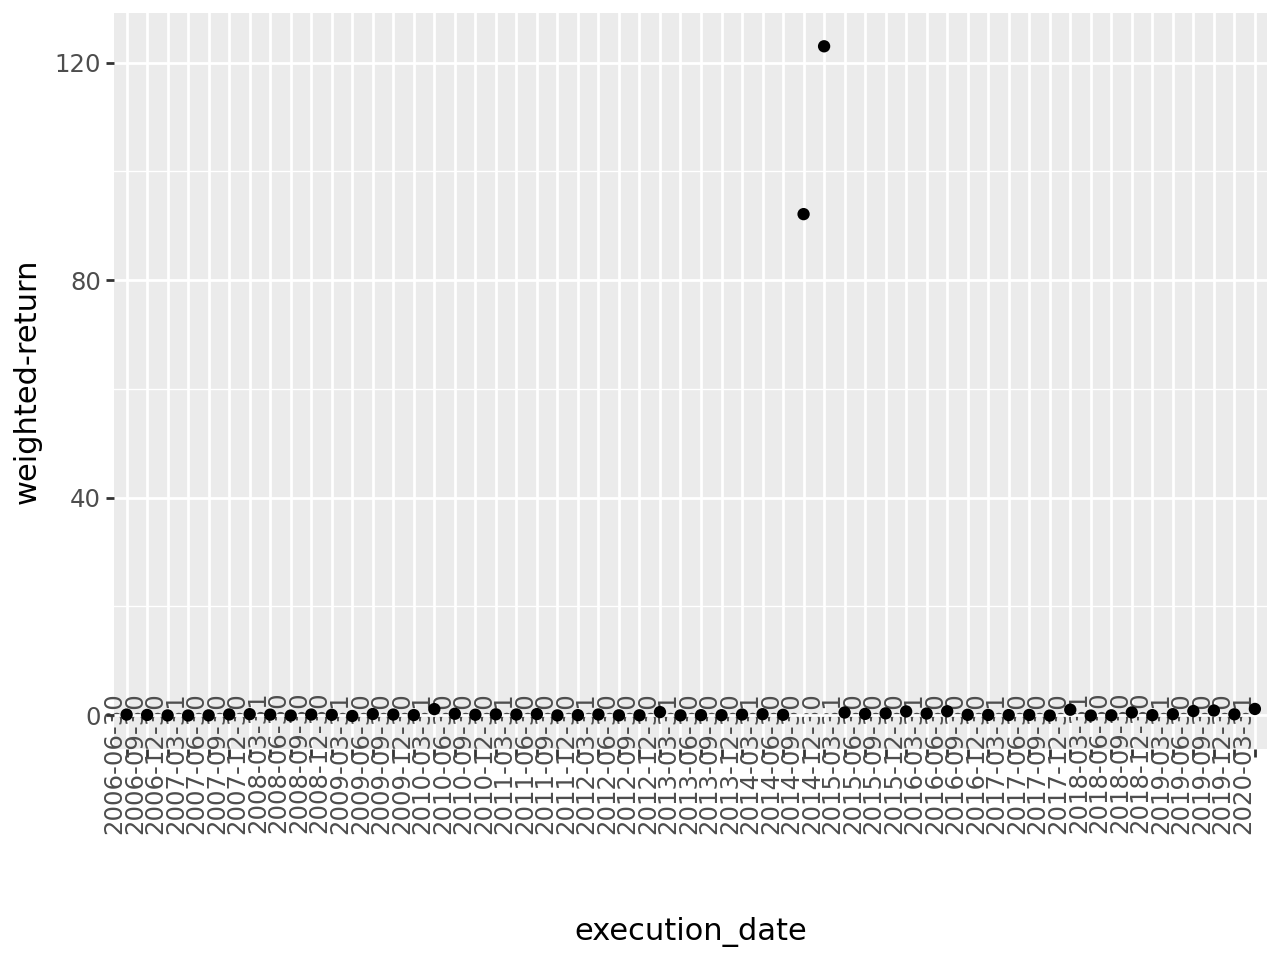

In [23]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

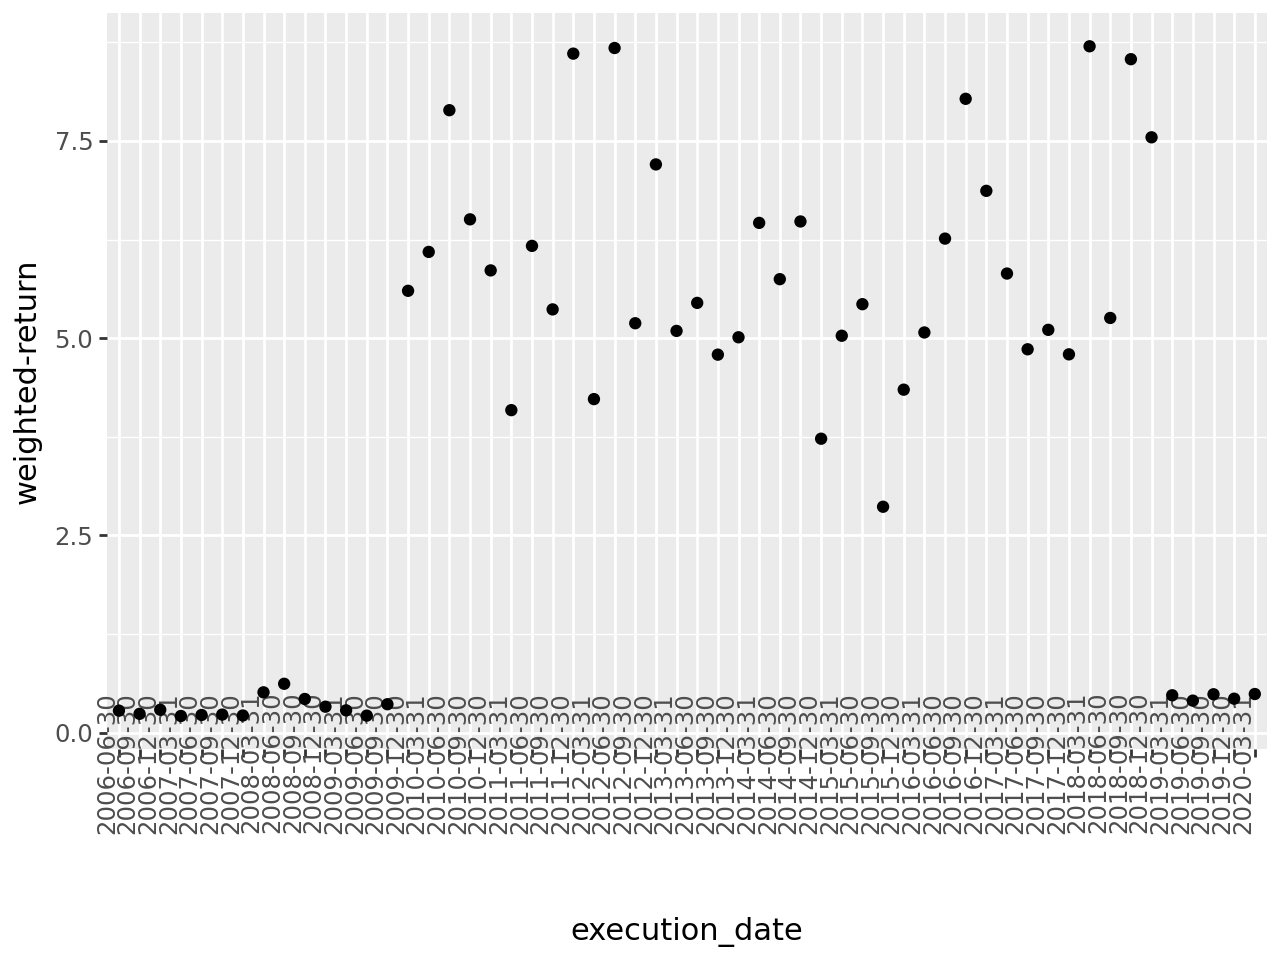

In [24]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [25]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot

# Start of Module 5

The previous graph can be our Baseline (with ML). We just modified the columns proposed to remove, adding a few ones that have future values.

We can also see that our model is clearly overfitting, as the results from train are way better than those from test.

To continue with the assessment we will do the following:

- Create a function to plot the previous graphs
- Create a baseline with no ML
- Analyze the columns and features, looking for correlation, distribution of missing values...
- After that we will see different ways to remove columns or fill missing values to see if performance improves
- Then we will use SHAP and feature permutation
- Finally we'll tweak our model changing it's hyperparameters and the metric to evaluate

Baseline (ML)

First we want to see the feature importane of the models 'out of the box', without modifying anything. We will check it for the last execution date.

We will create a function for quicker execution and comparison of the different changes we make.

In [26]:
def plot_results():
    test_results = parse_results_into_df("valid_0")
    train_results = parse_results_into_df("training")
    test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
    train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
    test_plot = (ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ggtitle("Test Results"))
    train_plot = (ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ggtitle("Train Results"))
    
    print(test_plot) 
    print(train_plot)

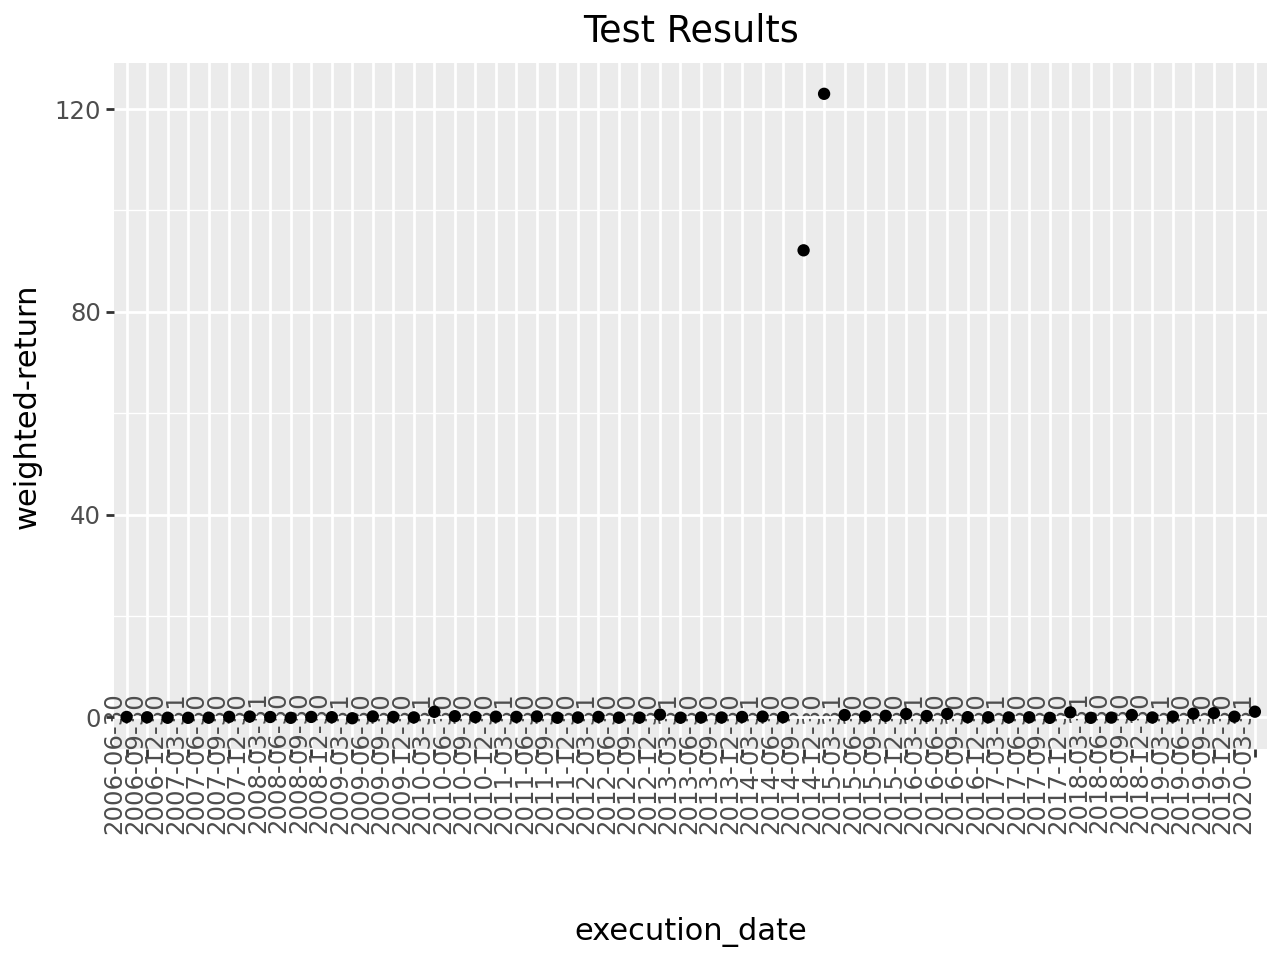

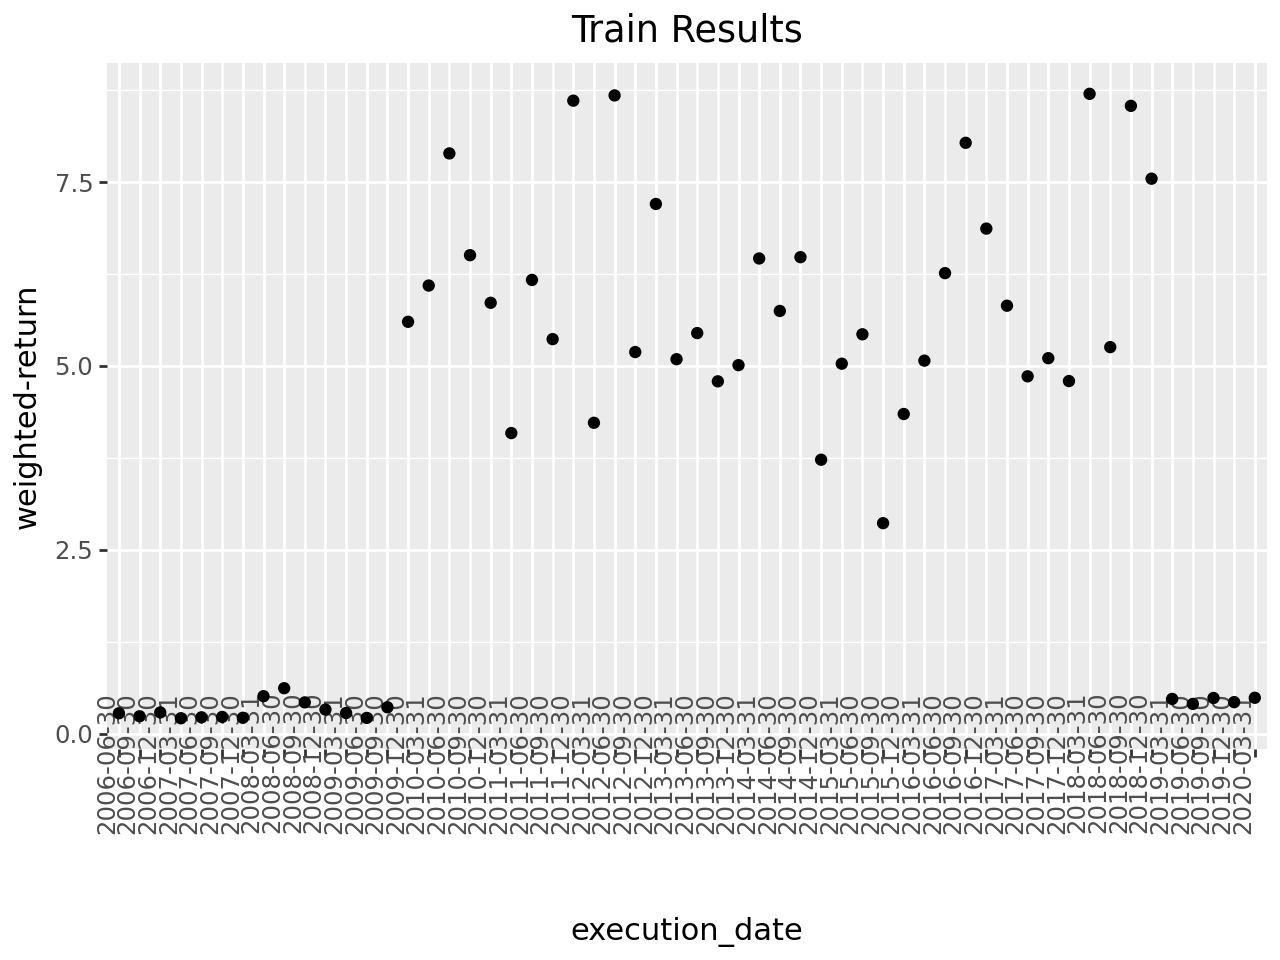

In [27]:
plot_results()

We see that the top 15 featues are important and cannot discard any feature yet.

After only modifiying the columns to drop in the `get_columns_to_drop()` we see a very very light performance increase in the weighted return (images are above). For now we have only modified the columns to drop to avoid data leakage.

### Baseline (no ML)

The simplest baseline will consist of the assumption that the best returns will be given by the stocks that were the best the previous year.

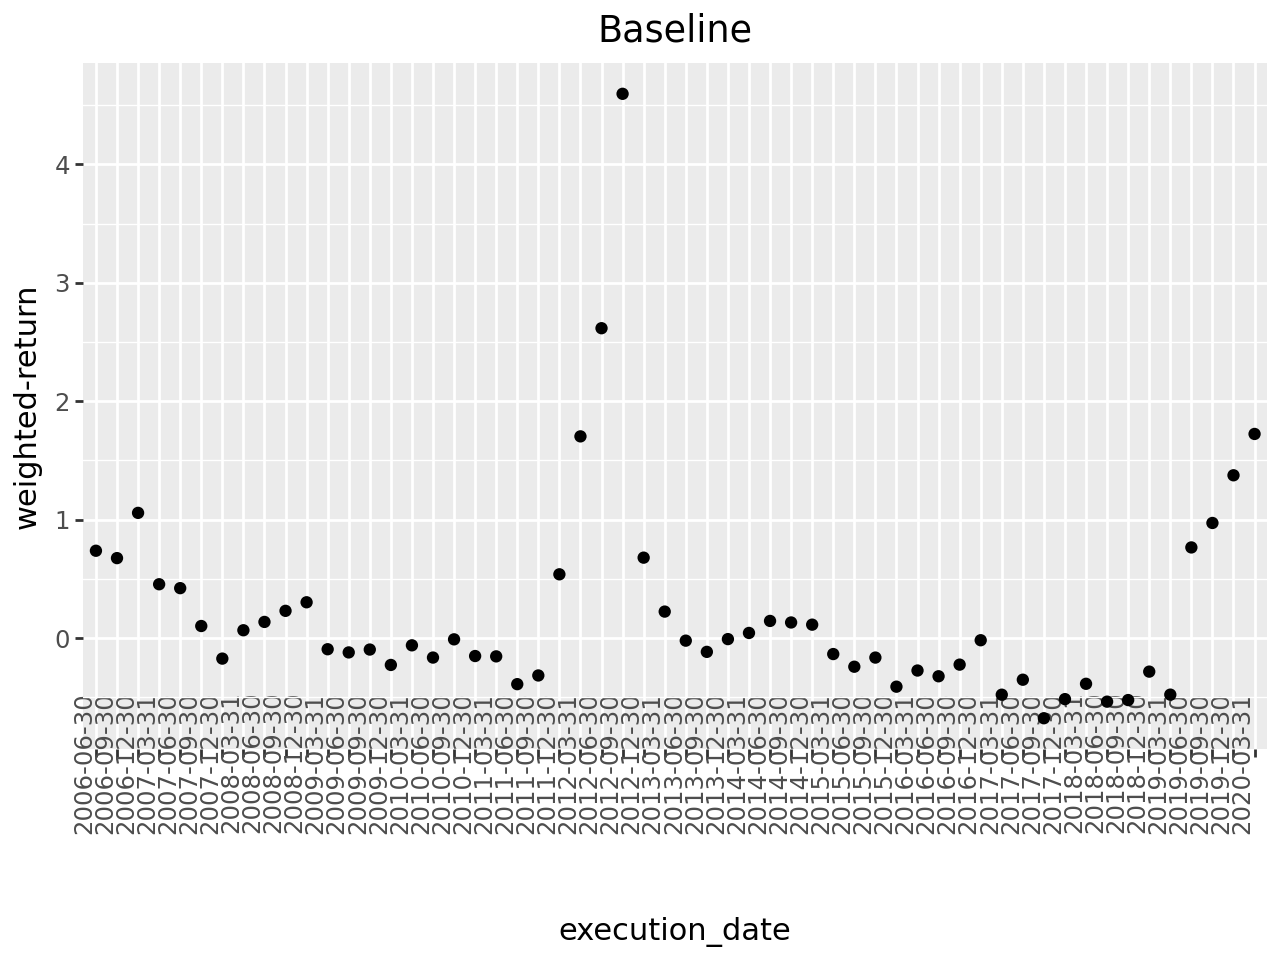

In [28]:
execution_dates = np.sort(data_set['execution_date'].unique())
df = {
    "execution_date":[],
    "weighted-return":[]

}
for execution_date in execution_dates:
    data_previous_year = data_set.loc[data_set["execution_date"] <= pd.to_datetime(execution_date) - pd.Timedelta(350, unit = "day")]
    if data_previous_year.shape[0] > 0:
        top_stocks = data_previous_year.sort_values('diff_ch_sp500', ascending=False).head(top_n)['Ticker'].tolist()
        data_current_year = data_set[data_set['execution_date'] == execution_date]
        baseline_data = data_current_year[data_current_year['Ticker'].isin(top_stocks)]
        if not baseline_data["diff_ch_sp500"].isna().any():
            baseline_weighted_performance = get_weighted_performance_of_stocks(baseline_data, "diff_ch_sp500")
        
            df["execution_date"].append(execution_date)
            df["weighted-return"].append(baseline_weighted_performance)

baseline_df = pd.DataFrame(df)
baseline_df["execution_date"] = baseline_df["execution_date"].astype(str)
(ggplot(baseline_df) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ggtitle("Baseline"))


We can see that the baseline model has very little performance, with some quarters yielding negative returns. Although some of the quarters, even with little returns, are far better than our initial ML baseline, where we only yield results for 4 quarters.

Let's try to improve this.

In [29]:
# We also will create this two helper functions in order to reset the dataset to its initial state as we will fill missing values and will remove some columns

def reset_dataset_():
    data_set = pd.read_feather("../../../Module 5/financials_against_return.feather")
    df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
    data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
    data_set = data_set[data_set["count"]>=minimum_number_of_tickers]
    data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]
    data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
    data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0
    data_set = data_set.drop(["EBITDAMargin"], axis=1)
    execution_dates = np.sort( data_set['execution_date'].unique() )
    return data_set, execution_dates

### First analysis

After analyzing all the Financial Variables one by one in Macrotrends, we can see that some variables are the same, and others will always be null. As we have +140 columns, reducing the number of columns we'll help us reduce the dimensionality, and also remove correlated features.

- IncomeAfterTaxes = IncomeFromContinuousOperations = NetIncome = NetIncomeLoss
    - The most important one will be NetIncome, so we can drop the others

* TotalAssets = TotalLiabilitiesAndShareHoldersEquity
    * Same values as Assets = Liabilities + SH Equity, we drop the right side of the equation

- OperatingIncome = EBIT
    - Besides EBIT is calculated annually (current Q + 3 previous quarters, the values here, don't match with those on macrotrends) and we want data quarterly, so we drop EBIT

* NetCommonEquityIssuedRepurchased = NetTotalEquityIssuedRepurchased
    * Drop the first one

- NetChangeInShort_minus_termInvestments = NetChangeInInvestments_minus_Total
    - Drop the first one

* EBITMargin = OperatingMargin
    * Drop the first one

- ReturnOnTangibleEquity = ROE
    - Drop the first one

* TotalCommonAndPreferredStockDividendsPaid = CommonStockDividendsPaid
    * Drop the first one

- EBITDA, NetCashFlow, ResearchAndDevelopmentExpenses, and Revenue values are not quarterly, but rather annually, we can drop them
- InvestingActivities_minus_Other and OperatingExpenses are calculated differently from Macrotrends, the values don't match, we can drop them.

**Null Columns**
- EBITDA Margin
- IncomeFromDiscontinuedOperations
- OtherIncome
- OtherOperatingIncomeOrExpenses
- OtherShareHoldersEquity
- Pre_minus_PaidExpenses

**Columns with some NaN values**
- GoodwillAndIntangibleAssets
- NetChangeInIntangibleAssets
- NetChangeInLong_minus_TermInvestments
- NetLong_minus_TermDebt


After reading the prior statements, it's important to take into account the following:

1. The above conclusions are drawn only from `AAPL` stock and the financial variables from Macrotrends.
2. For equal columns, we need to check for other stocks and also double check with correlation matrix (next cell).
3. For complete null columns, we need to check if it's a common ocurrence for other stocks to see if we can drop those columns completely.
    - We'll do this by checking the total % of null values in a column.
4. For columns with only some null values, after checking with Macrotrends, it makes sense to put a 0 in there.
    - Computing the mean or median doesn't make sense, because it can mean that that value can perfectly be a 0.
5. For columns with annually values instead of quarterly???
6. For columns whose values don't match those on Macrotrends???



#### For equal columns, we need to check for other stocks and also double check with correlation matrix

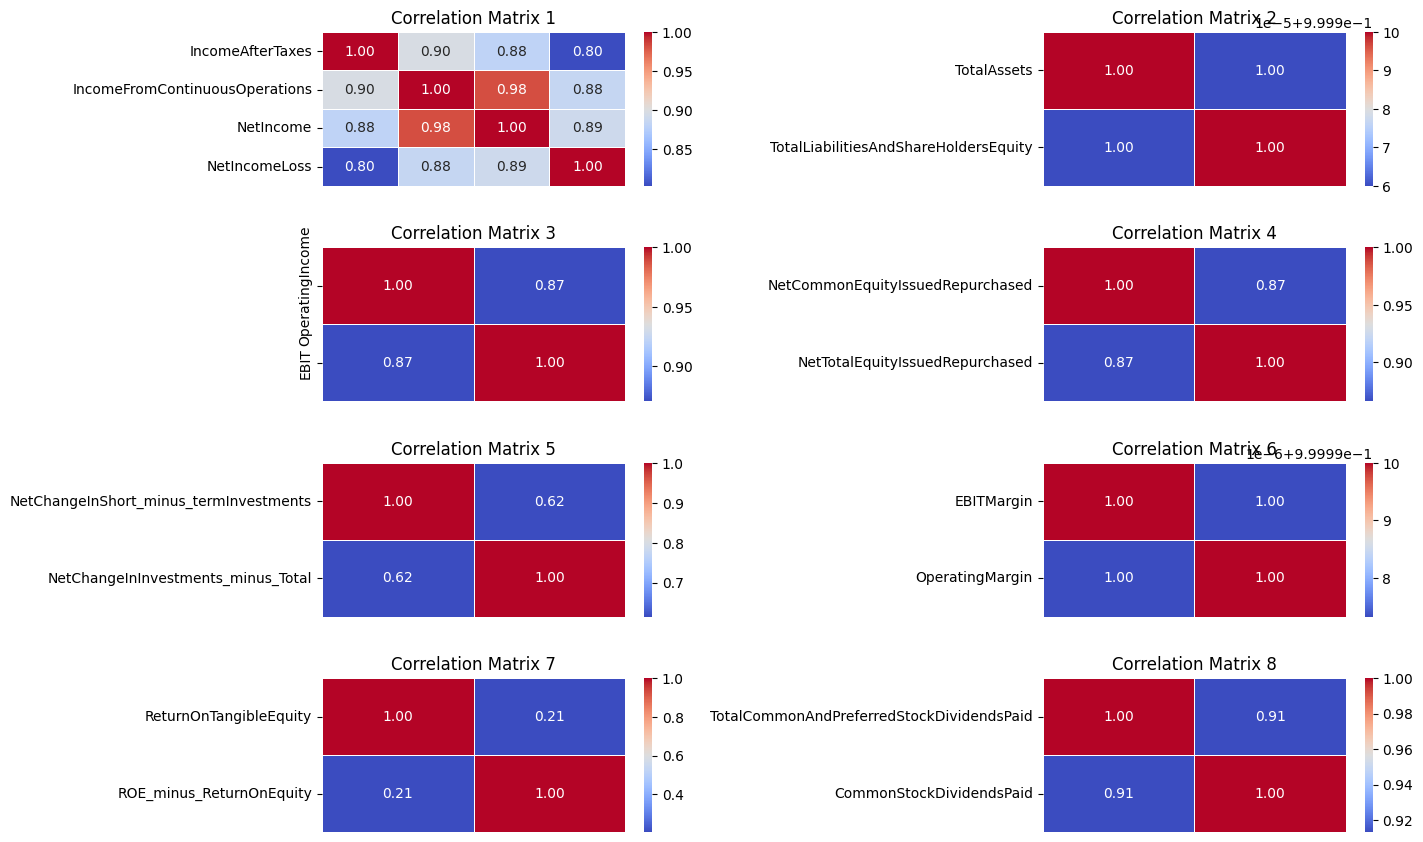

In [30]:
mx_1 = data_set[["IncomeAfterTaxes", "IncomeFromContinuousOperations", "NetIncome", "NetIncomeLoss"]] 
mx_2 = data_set[["TotalAssets", "TotalLiabilitiesAndShareHoldersEquity"]]
mx_3 = data_set[["OperatingIncome", "EBIT"]]
mx_4 = data_set[["NetCommonEquityIssuedRepurchased", "NetTotalEquityIssuedRepurchased"]]
mx_5 = data_set[["NetChangeInShort_minus_termInvestments", "NetChangeInInvestments_minus_Total"]]
mx_6 = data_set[["EBITMargin", "OperatingMargin"]]
mx_7 = data_set[["ReturnOnTangibleEquity", "ROE_minus_ReturnOnEquity"]]
mx_8 = data_set[["TotalCommonAndPreferredStockDividendsPaid", "CommonStockDividendsPaid"]]

data_sets = [mx_1, mx_2, mx_3, mx_4, mx_5, mx_6, mx_7, mx_8]

# Create the figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))  # Adjust figsize if needed

# Iterate through subplots and datasets
for i, (data, ax) in enumerate(zip(data_sets, axes.flatten())):
    corr_matrix = data.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=ax)
    ax.set_title(f"Correlation Matrix {i+1}")
    ax.set_xticks([])  # Set empty list to hide ticks
    ax.set_xticklabels([])

# Adjust layout for better spacing
plt.subplots_adjust(left=0.1, bottom=0.1, right=1.2, top=0.9, wspace=0.9, hspace=0.4)
plt.show()

After watching carefullly the previous correlation matrices, we will only drop the following columns:
- IncomeFromContinuousOperations
- NetIncomeLoss
- TotalLiabilitiesAndShareHoldersEquity
- EBIT
- NetCommonEquityIssuedRepurchased
- EBITMargin
- CommonStockDividendsPaid

#### For complete null columns, we need to check if it's a common ocurrence for other stocks to see if we can drop those columns completely.

In [31]:
import missingno as msno

null_columns = ["EBITDAMargin", "IncomeFromDiscontinuedOperations", "OtherIncome", "OtherOperatingIncomeOrExpenses", "OtherShareHoldersEquity", "Pre_minus_PaidExpenses"]

msno.bar(data_set[null_columns], figsize=(7, 3), color='steelblue')


<Axes: >

In [32]:
for col in null_columns:
    null_vals = data_set[col].isnull().sum()
    tot_vals = len(data_set[col])
    print(f"{col}: {null_vals/tot_vals:.2%}")

EBITDAMargin: 100.00%
IncomeFromDiscontinuedOperations: 80.83%
OtherIncome: 96.06%
OtherOperatingIncomeOrExpenses: 66.69%
OtherShareHoldersEquity: 86.11%
Pre_minus_PaidExpenses: 50.72%


After checking the null columns, we will drop the following, understanding why
- EBITDAMargin
    - Only has null values, no information loss
* OtherIncome
    * A lot of null values
    * Also, most companies income comes from its OperatingIncome
- OtherShareholdersEquity, 
    - Nulll values and value is included in "TotalLiabilities" so we can drop it
*  IncomeFromDiscontinuedOperations
    * This is the profit made, if any, in the accounting period in which the operation was discontinued.
    * We assume all companies are active companies and make are in operation


In [33]:
tech_features = ["close_0",	"close_sp500_0", "stock_change_365", "stock_change_div_365",
                 "sp500_change_365", "stock_change_730", "stock_change_div_730", "sp500_change_730",
                 "stock_change__minus_120", "stock_change_div__minus_120", "sp500_change__minus_120",
                 "stock_change__minus_365", "stock_change_div__minus_365", "sp500_change__minus_365",
                 "stock_change__minus_730", "stock_change_div__minus_730", "sp500_change__minus_730",
                 "std_730", "std__minus_120", "std__minus_365", "std__minus_730"]

enterprise_features = ["Market_cap", "n_finan_prev_year", "Enterprisevalue", "EBITDAEV", "EBITEV",
                       "RevenueEV", "CashOnHandEV", "PFCF", "PE", "PB", "RDEV", "WorkingCapital", "ROC",
                       "DividendYieldLastYear", "EPS_minus_EarningsPerShare_change_1_years", "EPS_minus_EarningsPerShare_change_2_years",
                       "FreeCashFlowPerShare_change_1_years", "FreeCashFlowPerShare_change_2_years", "OperatingCashFlowPerShare_change_1_years",
                       "OperatingCashFlowPerShare_change_2_years", "EBITDA_change_1_years", "EBITDA_change_2_years", "EBIT_change_1_years",
                       "EBIT_change_2_years", "Revenue_change_1_years", "Revenue_change_2_years", "NetCashFlow_change_1_years", "NetCashFlow_change_2_years",
                       "CurrentRatio_change_1_years", "CurrentRatio_change_2_years", "Market_cap__minus_365", "Market_cap__minus_730"]

object_feat = ["Ticker", "date", "execution_date"]

target = ["diff_ch_sp500"]

financial_features = [feat for feat in data_set.columns if feat not in tech_features and feat not in enterprise_features and feat not in object_feat and feat not in target]

### Correlation

Due to financial data having correlated features, we will check the correlation between some features.

1. First we check how many columns we'd have left if we were to drop those features with a correlation higher than 0.85
2. Then we check the highly correlated features in the technical variables, financial variables and enterprise variables individually, to see if we can drop those that have a perfect correlation (~1.00)

In [34]:
# Dropping features with the whole dataset
df =data_set.drop(object_feat + target, axis=1)
df_corr = df.corr()
threshold = 0.85

columns = np.full((df_corr.shape[0],), True, dtype=bool)
for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]
print(len(df.columns))
print(len(selected_columns))

142
105


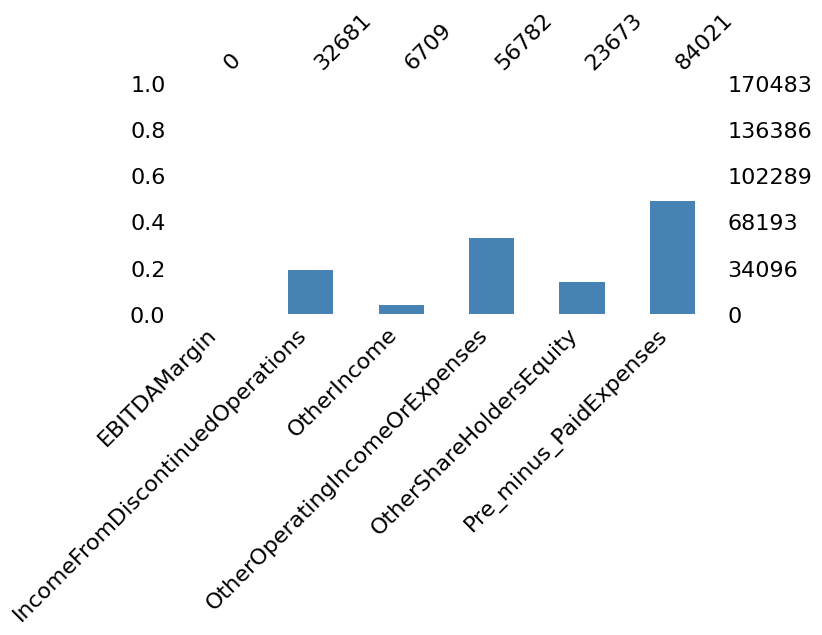

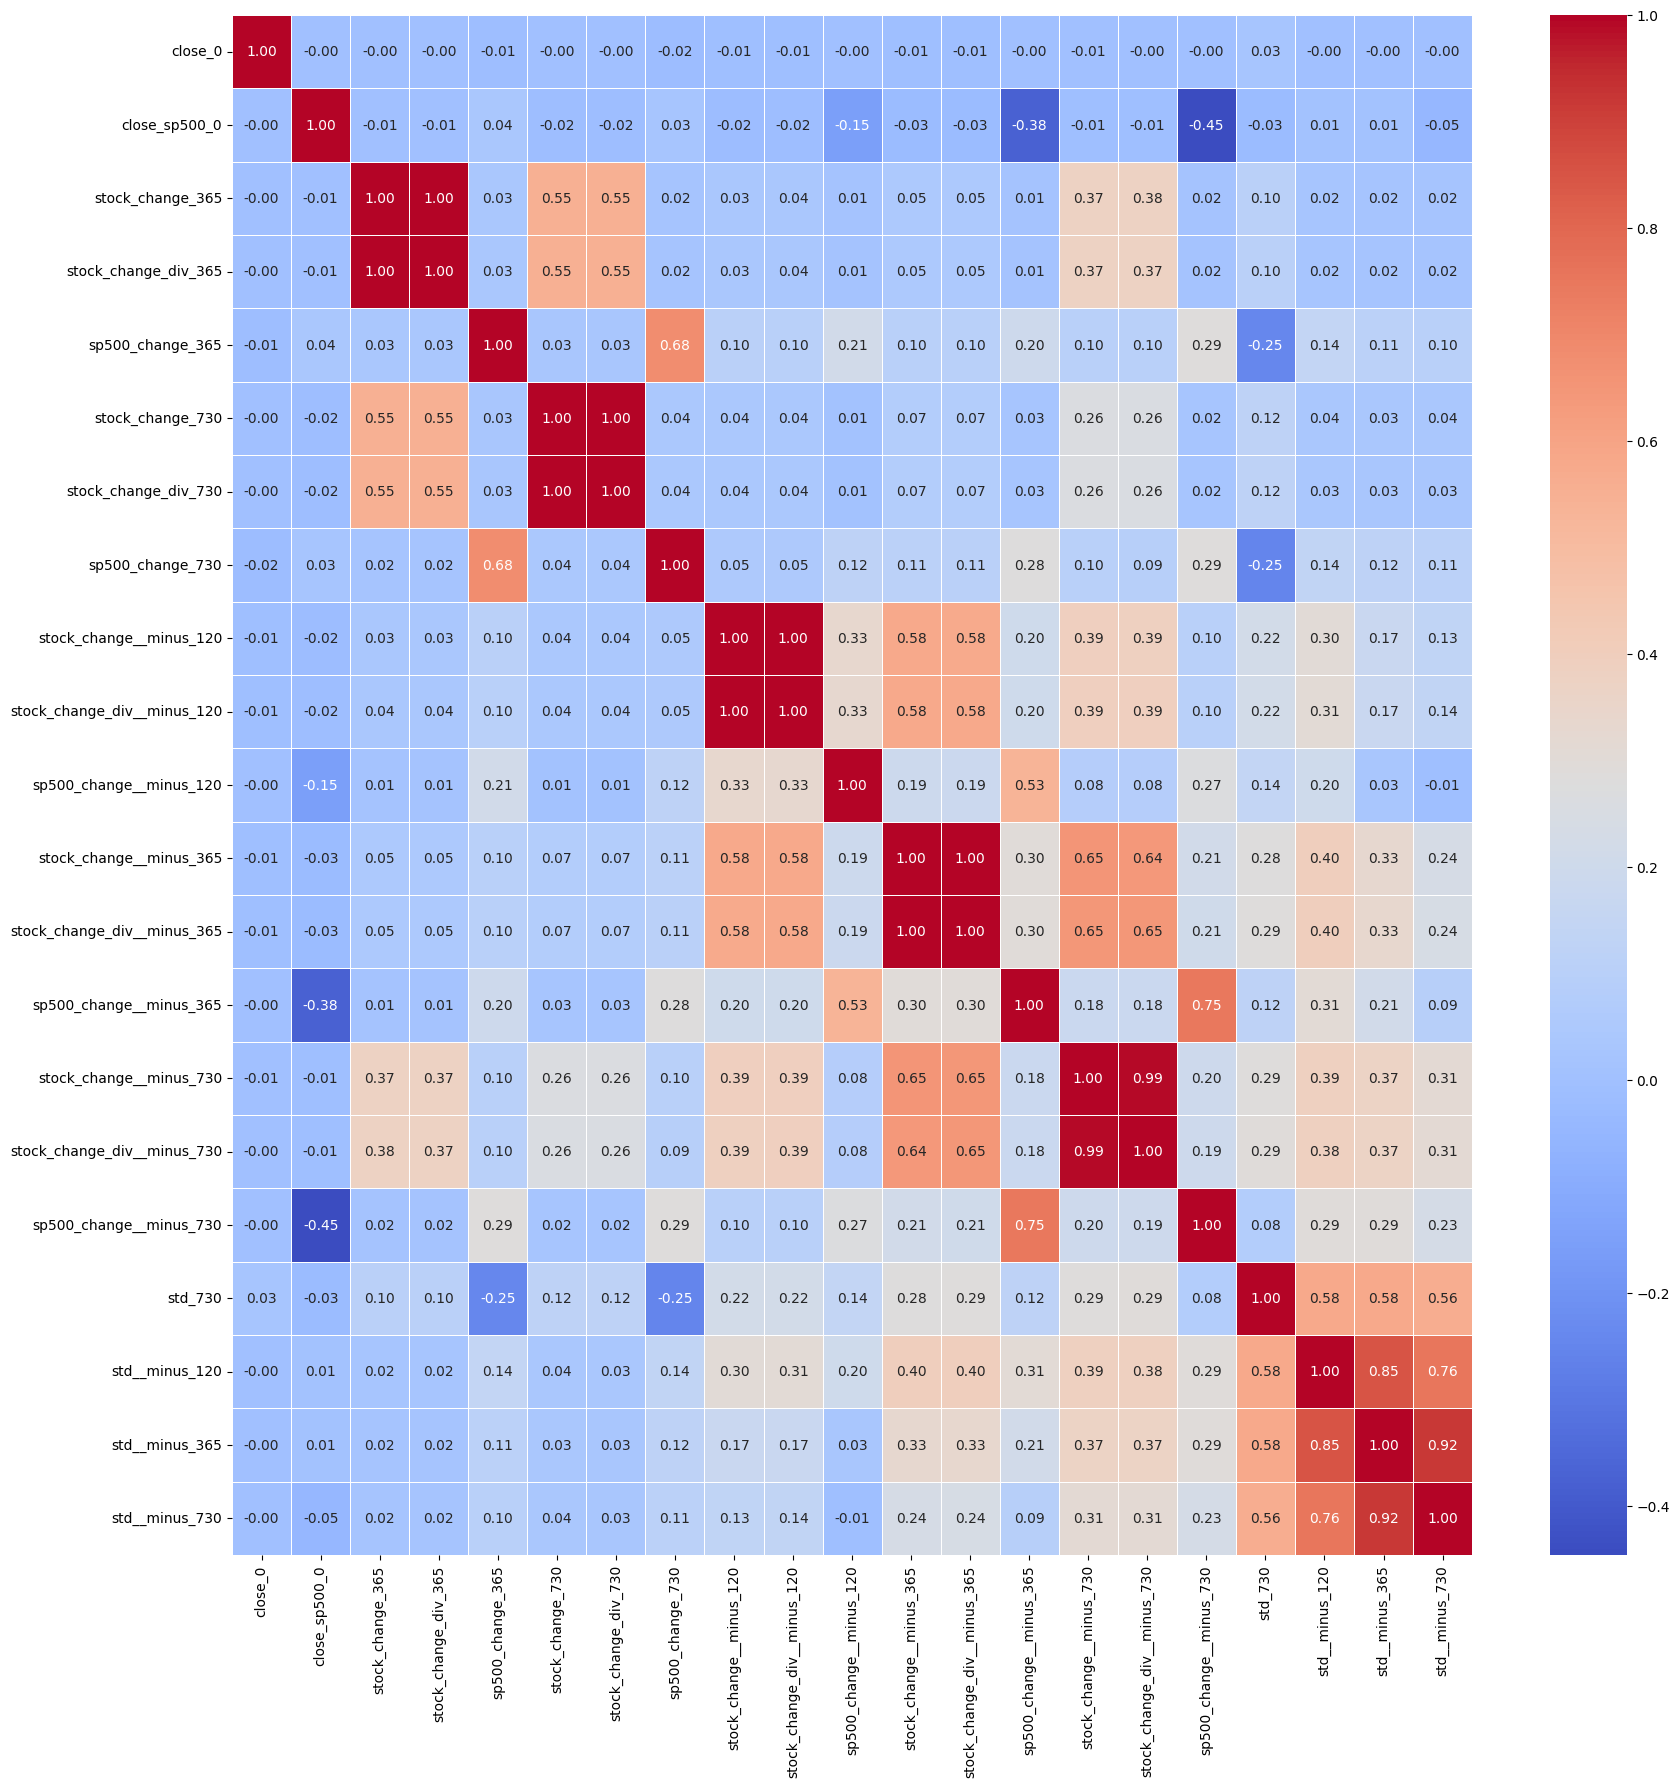

In [35]:
tech_feat_df = data_set[tech_features]
tech_corr = tech_feat_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(tech_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

We see that some columns have a correlation coefficient of 1, so it makes sense to just take one column. After checking the dataset, we can see that the following columns have the same exact values:

The features `stock_change365 and 730` and the others related, have already been dropped as they include future information.

We can drop:
- stock_change_div__minus_120
- stock_change_div__minus_365
- stock_change_div__minus_730

That are highly correlated with it's similar features (same name without the 'div')

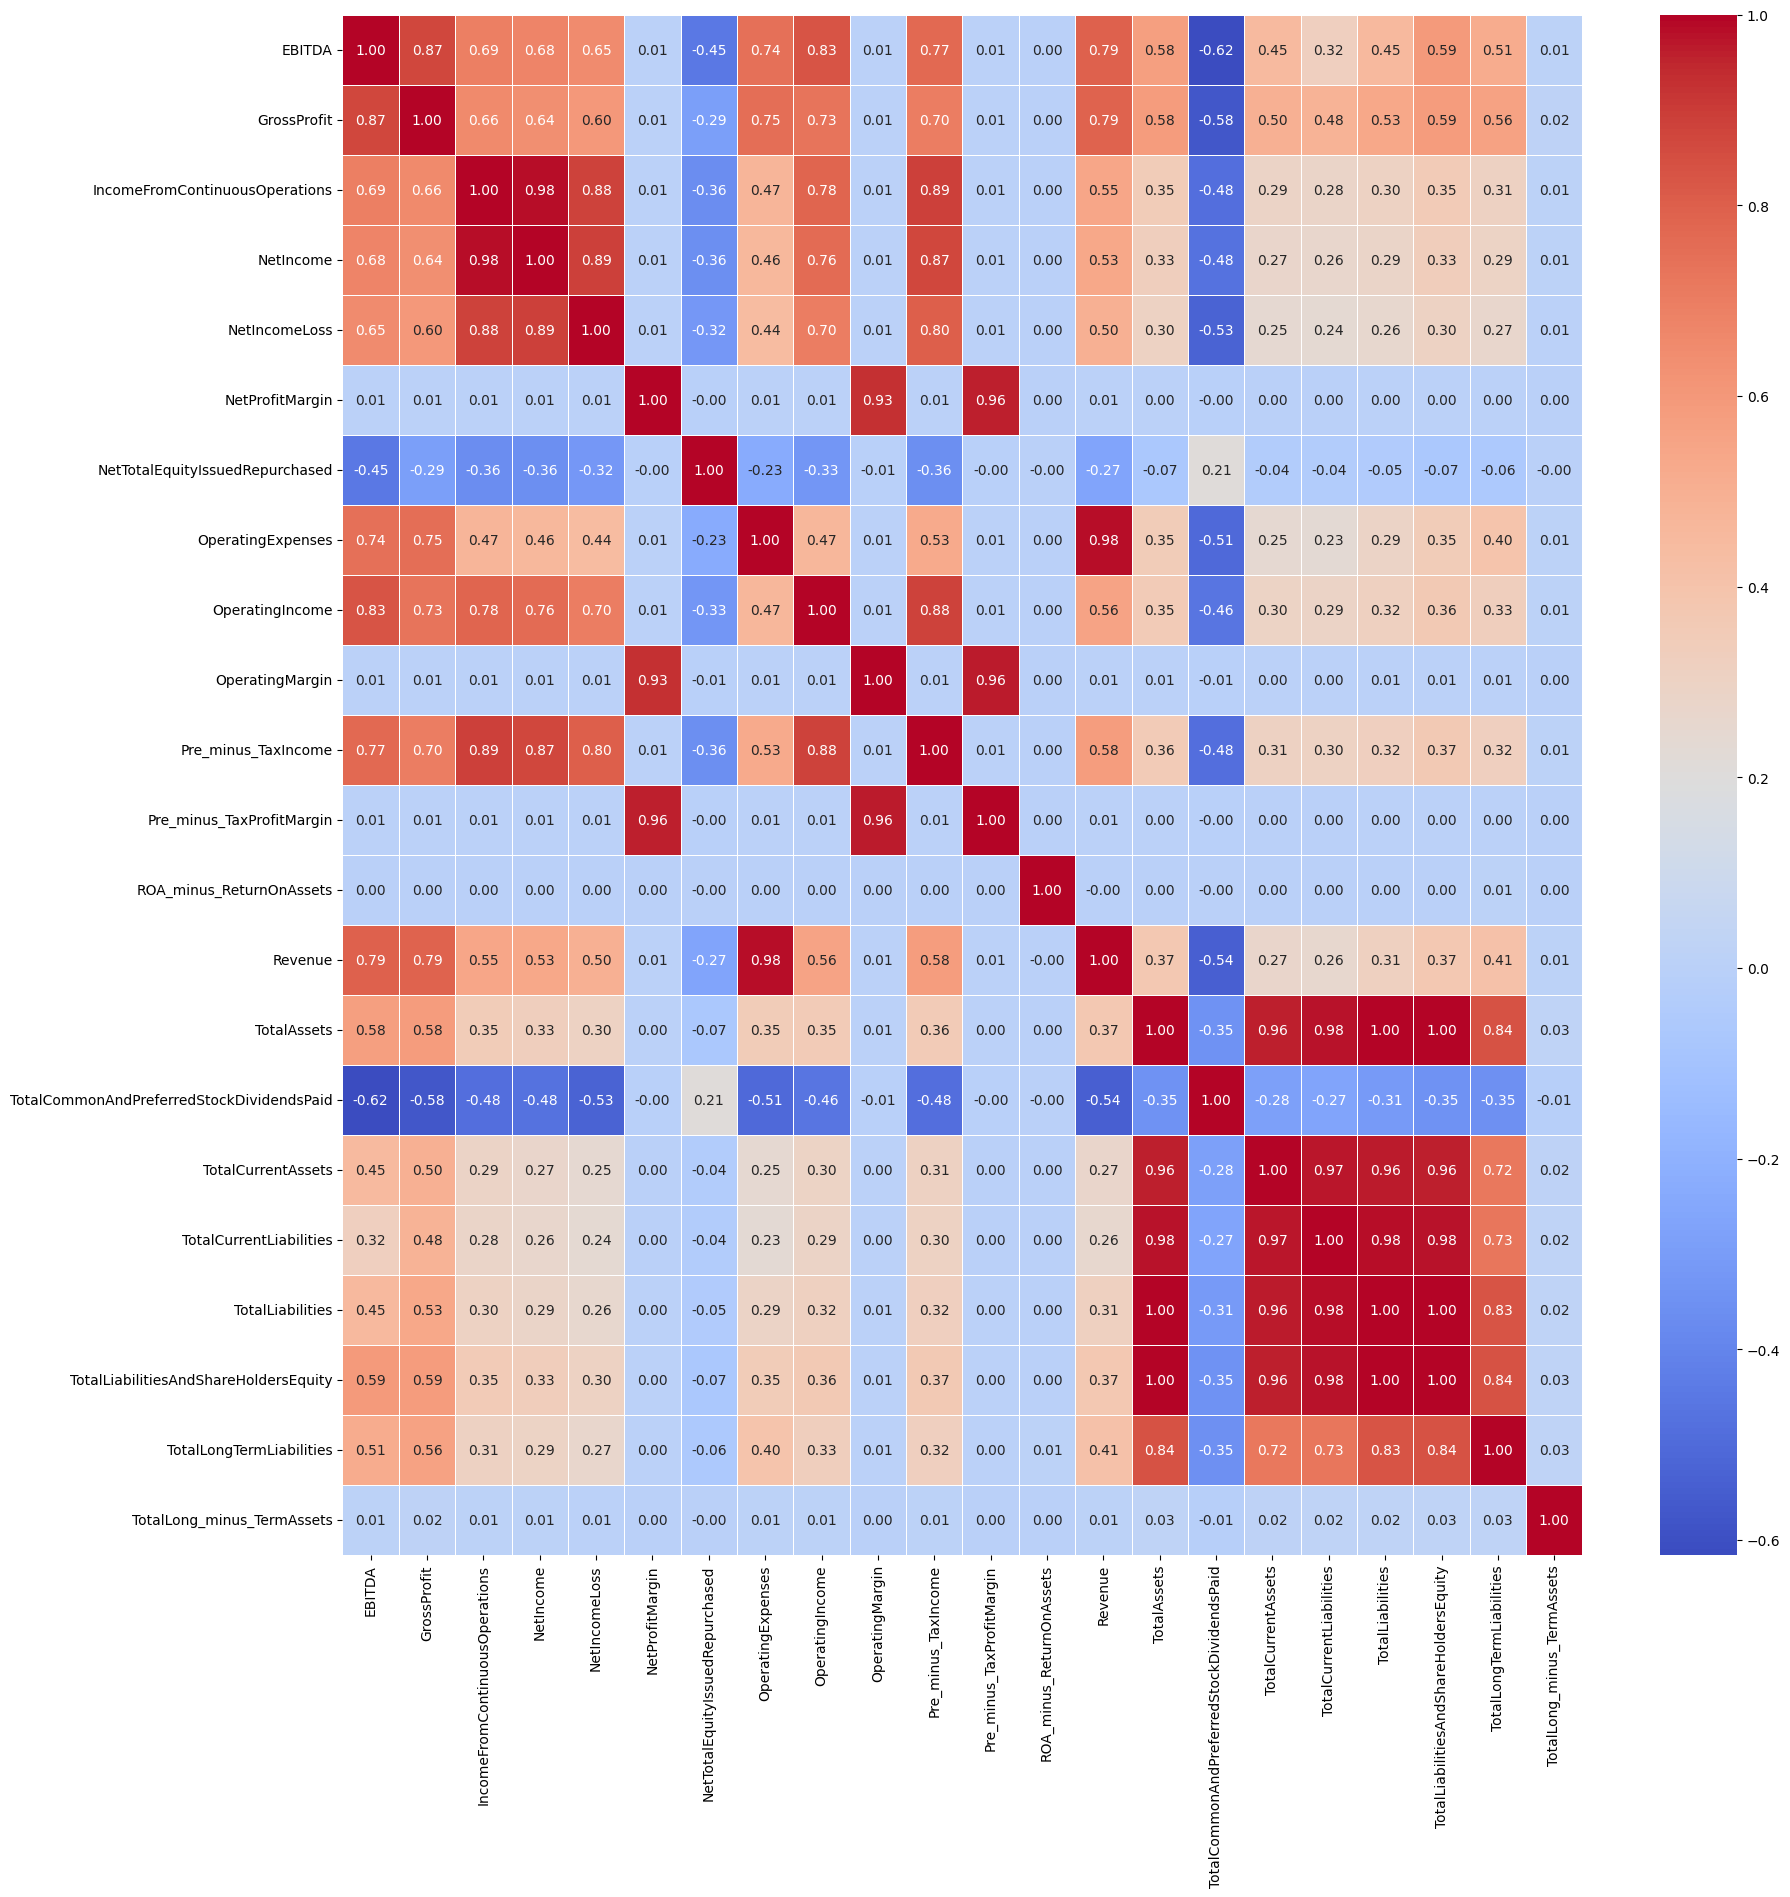

In [36]:
# Dropping features with the whole dataset
fin_feat_df =data_set[financial_features]
fin_corr = fin_feat_df.corr()
threshold = 0.85

columns = np.full((fin_corr.shape[0],), True, dtype=bool)
for i in range(fin_corr.shape[0]):
    for j in range(i+1, fin_corr.shape[0]):
        if fin_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
selected_columns = fin_feat_df.columns[~columns]

feat_df = data_set[selected_columns]
feat_corr = feat_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(feat_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

From this we can see several features that are highly correlated. We will drop the following:

- IncomeFromContinuousOperations ≈ NetIncome
    - Drop the first one
* Revenue ≈ OperatingExpenses
    * Drop the first one
    * Besides, Revenue values in this column are annuallized, not quarterly like the rest of the columns
- NetProfitMargin ≈ Pre_minus_TaxProfitMargin ≈ OperatingMargin
    - Drop the two first columns
* TotalLiabilities = TotalLiabilitiesAndShareHoldersEquity = TotalAssets
    * Drop the two first columns
- TotalCurrentAssets ≈ TotalCurrentLiabilities ≈ TotalAssets
    - Drop the two first columns

### Checking missing values

In [37]:
null_columns = data_set.columns[data_set.isnull().any()]
null_values = []
pct_values = []
for col in null_columns:
    null_vals = data_set[col].isnull().sum()
    tot_vals = len(data_set[col])
    pct = (null_vals/tot_vals)*100
    null_values.append(null_vals)
    pct_values.append(pct)
    
null_df = pd.DataFrame({"Column": null_columns, "Nulls": null_values, "Pct": pct_values})
null_df["Pct"] = null_df["Pct"].round(2).astype(str) + "%"
null_df.sort_values("Nulls", ascending=False)
    

,Column,Nulls,Pct
20,EBITDAMargin,170483,100.0%
52,OtherIncome,163774,96.06%
57,OtherShareHoldersEquity,146810,86.11%
27,IncomeFromDiscontinuedOperations,137802,80.83%
109,RDEV,114041,66.89%
...,...,...,...
99,std__minus_120,250,0.15%
100,std__minus_365,250,0.15%
101,std__minus_730,250,0.15%
107,PFCF,145,0.09%


In [38]:
null_cols = null_df["Column"].tolist()
null_cols.remove("diff_ch_sp500")

From the previous, maybe it makes sense to put a 0 where there are NaNs. After checking the official reports from the companies and the data from macrotrends, it means data was blank, so maybe we can put a 0.

In [39]:
def fill_nulls_zero(data_set, null_cols):
    data_set[null_cols] = data_set[null_cols].fillna(0)
    return data_set

Apart from checking just the percentage of missing values, it is important to check the distribution of them along time, as it is of crucial importance in this problem

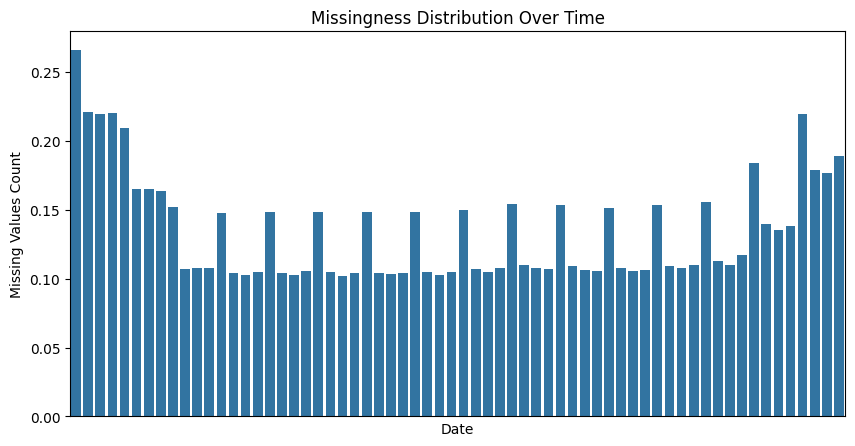

In [40]:
df_copy = data_set.sort_values("execution_date", ascending = True)
my_dates = df_copy["execution_date"].unique()

null_vals = []

max_nulls = 0

for date in my_dates:
    df_tmp = df_copy[df_copy["execution_date"] == date]
    tot_nulls = df_tmp.isnull().sum().sum() 
    pct_nulls = df_tmp.isnull().sum().sum() / (df_tmp.shape[0] * df_tmp.shape[1])
    null_vals.append(pct_nulls)
    nulls = df_tmp.shape[0] * df_tmp.shape[1]
    if nulls > max_nulls:
        max_nulls = nulls
    
null_df = pd.DataFrame({"Date": my_dates, "Nulls": null_vals})

plt.figure(figsize=(10, 5))
sns.barplot(x="Date", y="Nulls", data=null_df, width=0.8)  # Adjust width as desired
plt.xlabel('Date')
plt.ylabel('Missing Values Count')
plt.xticks([])
plt.title('Missingness Distribution Over Time')
plt.show()


We see that the missing values are constant in the center, so we could take only those to train our model. With this we still have more than one decade as training data and we can reduce the training time a bit.

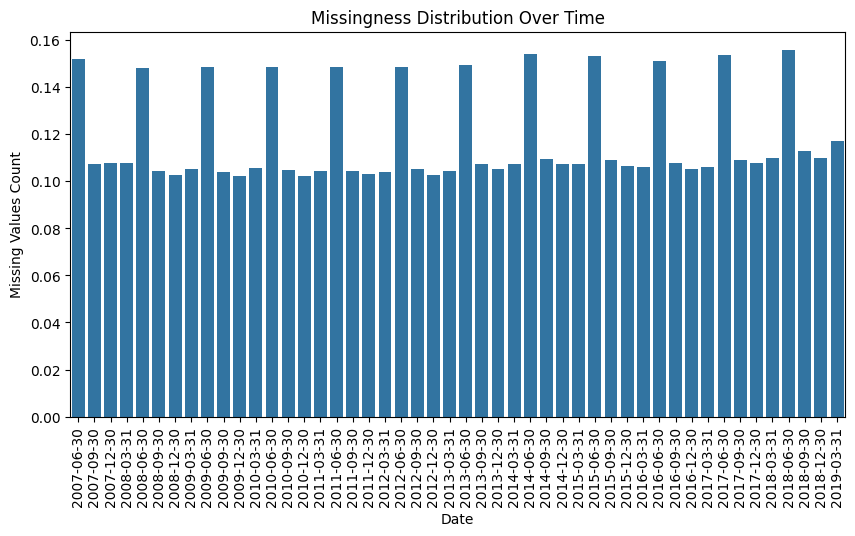

In [41]:
df_copy = df_copy.sort_values("execution_date", ascending = True)
my_dates = df_copy["execution_date"].unique()[8:-8]

null_vals = []

max_nulls = 0

for date in my_dates:
    df_tmp = df_copy[df_copy["execution_date"] == date]
    tot_nulls = df_tmp.isnull().sum().sum() 
    pct_nulls = df_tmp.isnull().sum().sum() / (df_tmp.shape[0] * df_tmp.shape[1])
    null_vals.append(pct_nulls)
    nulls = df_tmp.shape[0] * df_tmp.shape[1]
    if nulls > max_nulls:
        max_nulls = nulls
    
null_df = pd.DataFrame({"Date": my_dates, "Nulls": null_vals})

plt.figure(figsize=(10, 5))
sns.barplot(x="Date", y="Nulls", data=null_df, width=0.8)  # Adjust width as desired
plt.xlabel('Date')
plt.ylabel('Missing Values Count')
plt.xticks(rotation=90)
plt.title('Missingness Distribution Over Time')
plt.show()


### Removing columns

The only column we can drop is EBITDAMargin as it has 100% of missing vaues. We will iterate over dropping different columns to see if performance improves

In [42]:
data_set = data_set.drop(["EBITDAMargin"], axis=1)

In [43]:
execution_dates = np.sort(data_set['execution_date'].unique())[8:-8]

all_results = {}
all_predicted_tickers_list = []
all_models = {}
for execution_date in execution_dates:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, n_trees, False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

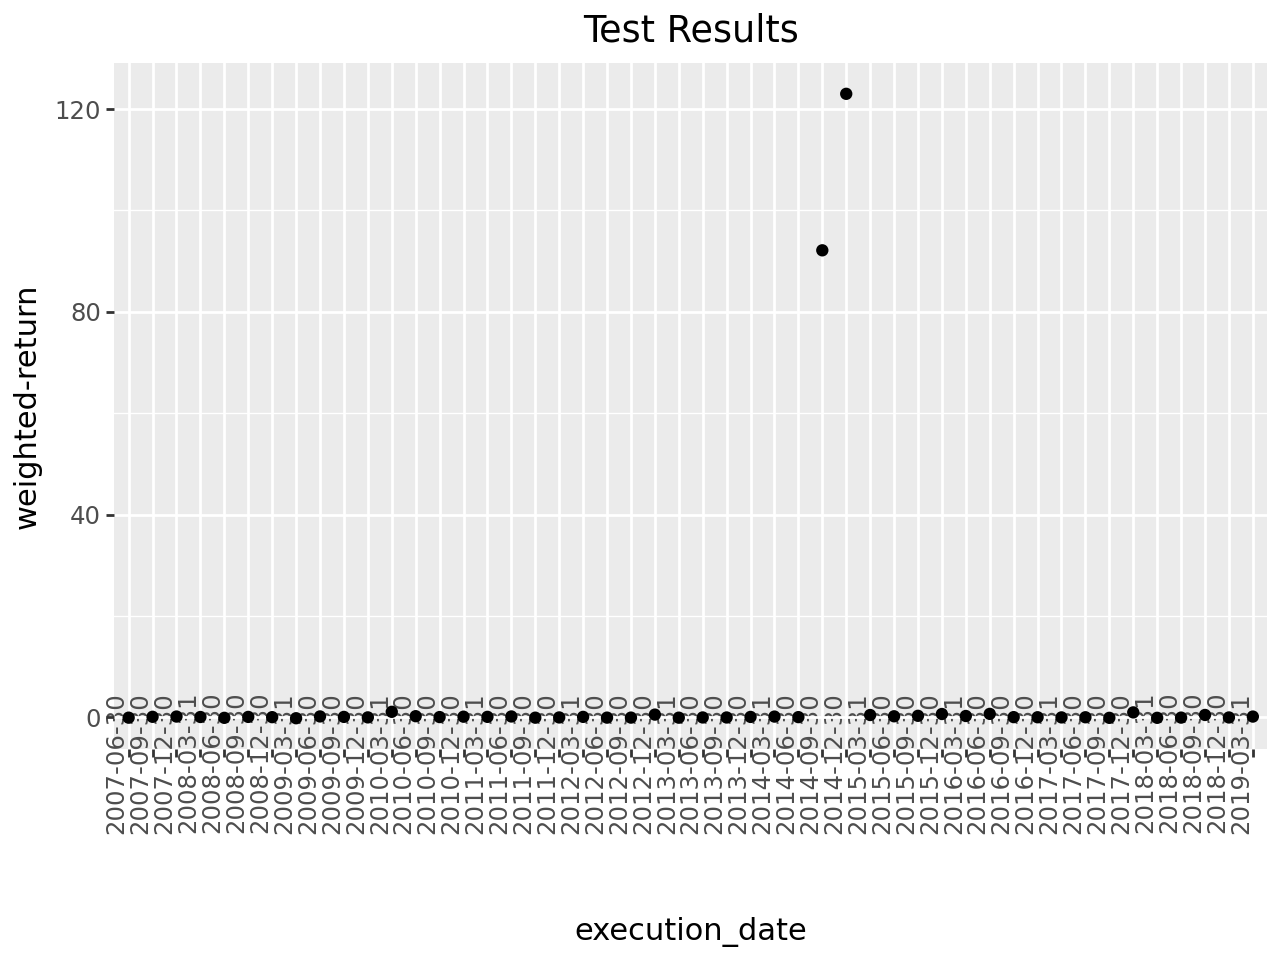

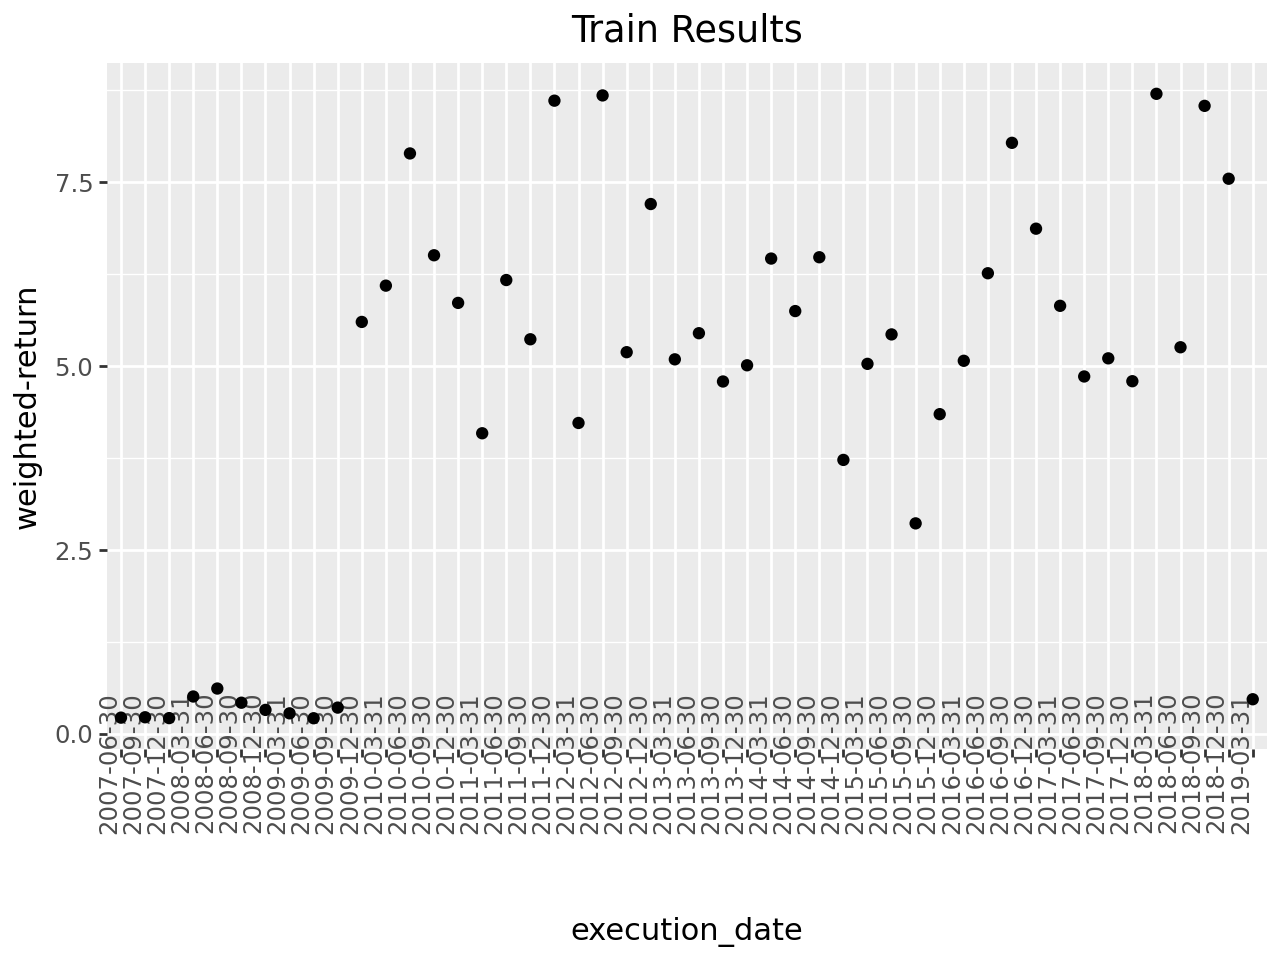

In [44]:
plot_results()

After removing one column and reducing the time period, performance is still the same, and as we have reduce the dataset, training time is now < 2 min. This time the importance of the features has shifted with respect to our Baseline.

Let's see how the performance is affected if we remove all the columns that we said previously that we will remove.

In [45]:

cols_to_drop = ["IncomeFromDiscontinuedOperations", "OtherIncome", "OtherShareHoldersEquity", # Null columns
                "stock_change_div__minus_120", "stock_change_div__minus_365", "stock_change_div__minus_730", # Same columns as those without the 'div', highly correlated.
                "IncomeFromContinuousOperations", "NetIncomeLoss", "TotalLiabilitiesAndShareHoldersEquity", "EBIT", "NetCommonEquityIssuedRepurchased", "EBITMargin", "CommonStockDividendsPaid", # Similar values
                "Revenue", "NetProfitMargin", "Pre_minus_TaxProfitMargin", "TotalLiabilities", "TotalCurrentAssets", "TotalCurrentLiabilities"] # High correlation


def drop_cols(data_set, cols_to_drop):
    return data_set.drop(cols_to_drop, axis=1, errors='ignore')

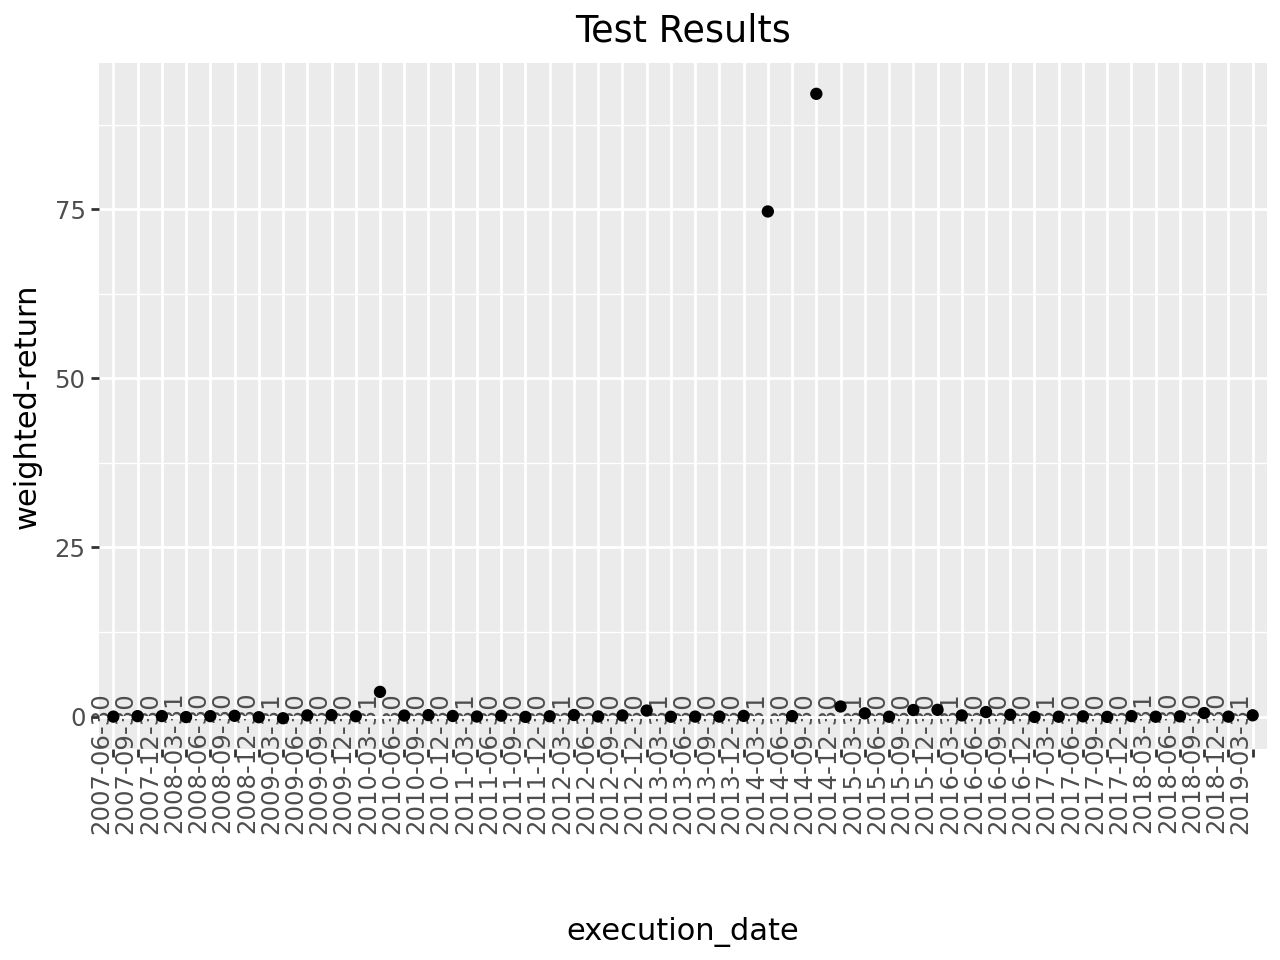

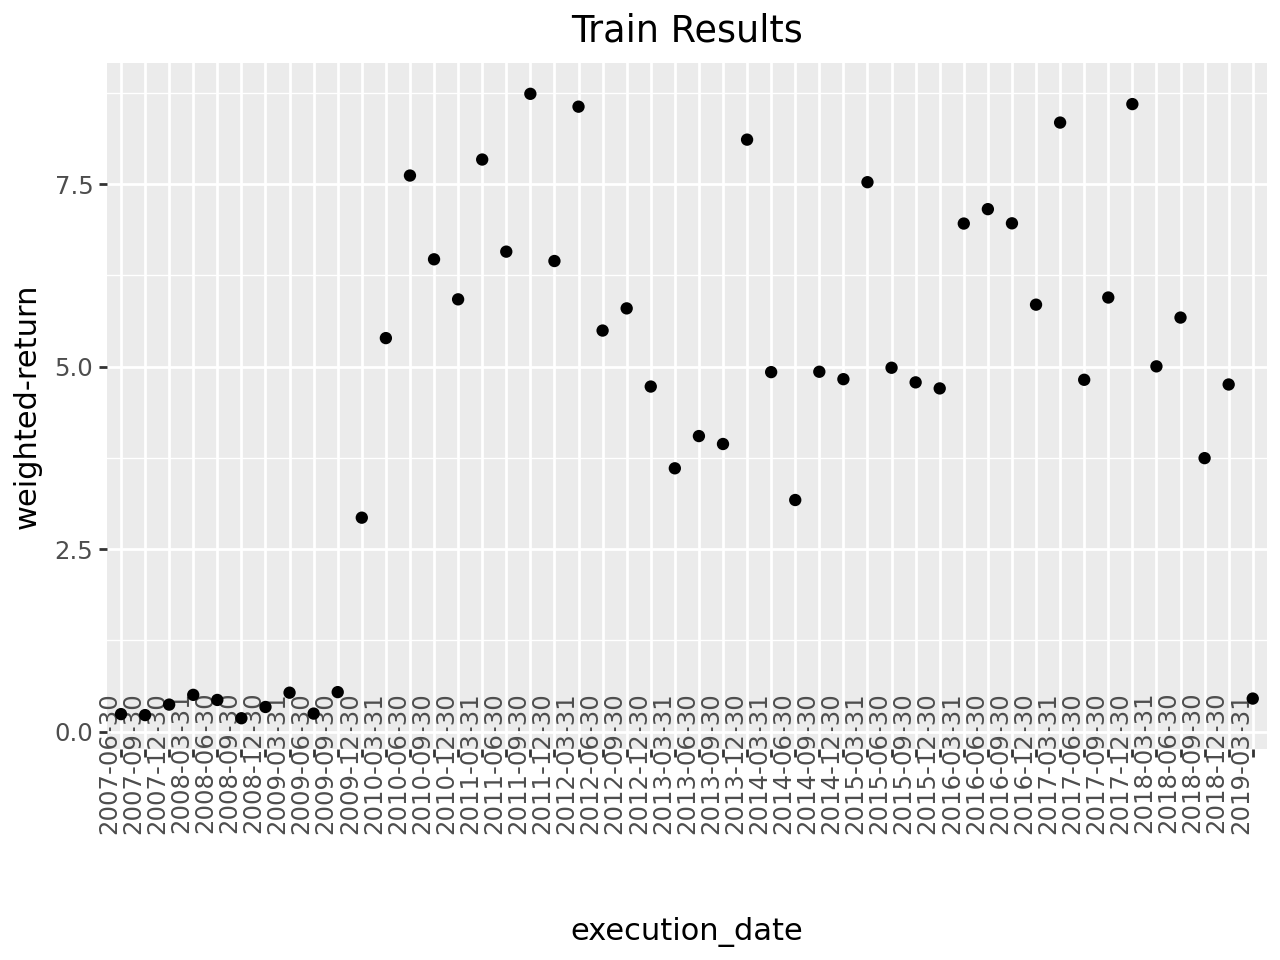

In [46]:
data_set = drop_cols(data_set, cols_to_drop)

all_results = {}
all_predicted_tickers_list = []
all_models = {}
for execution_date in execution_dates:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, n_trees, False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)
plot_results()

Performance is a bit worse than with all the columns. Let's remove columns step by step.

### Removing null columns

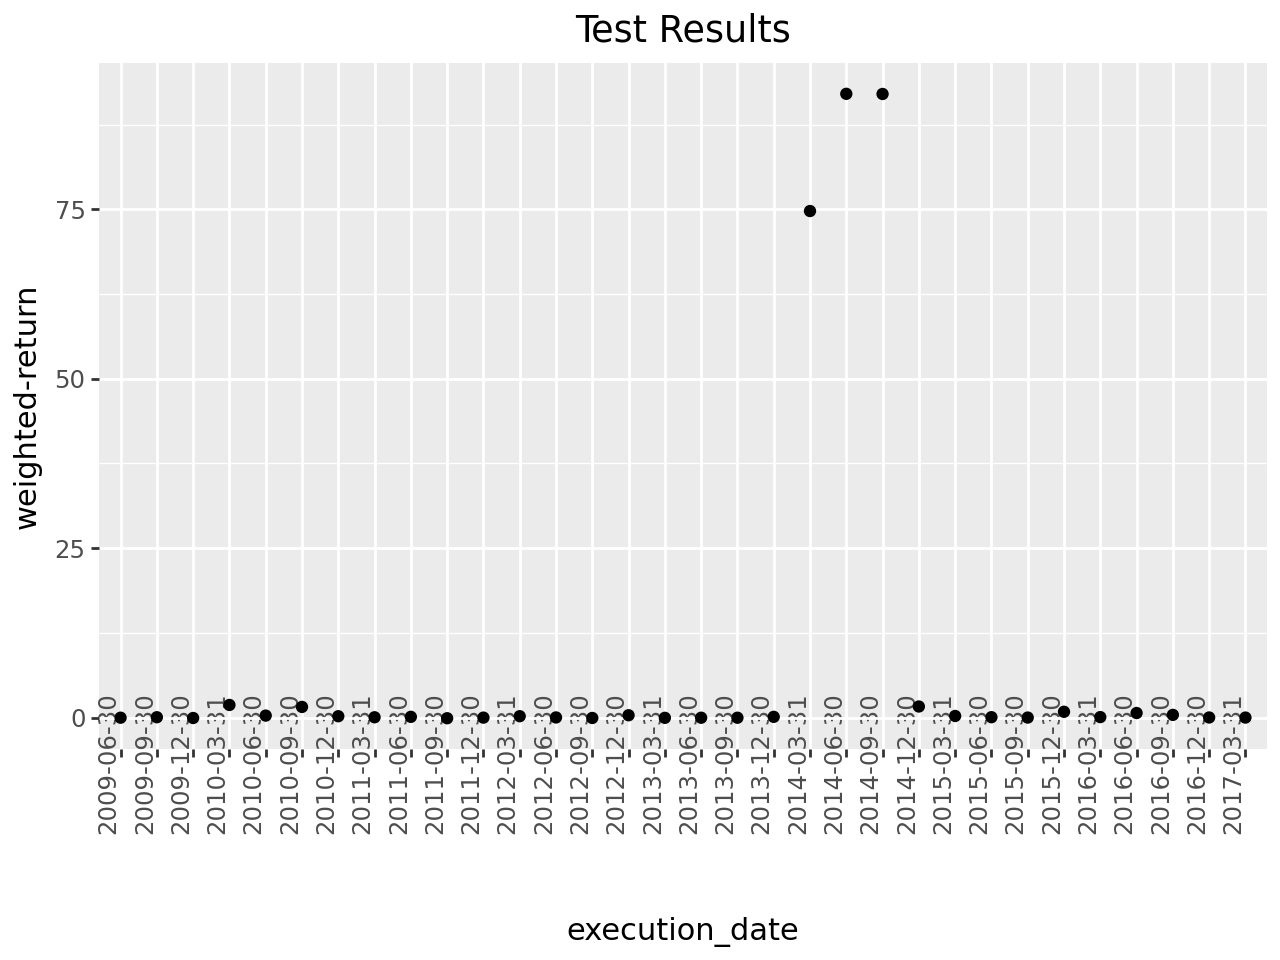

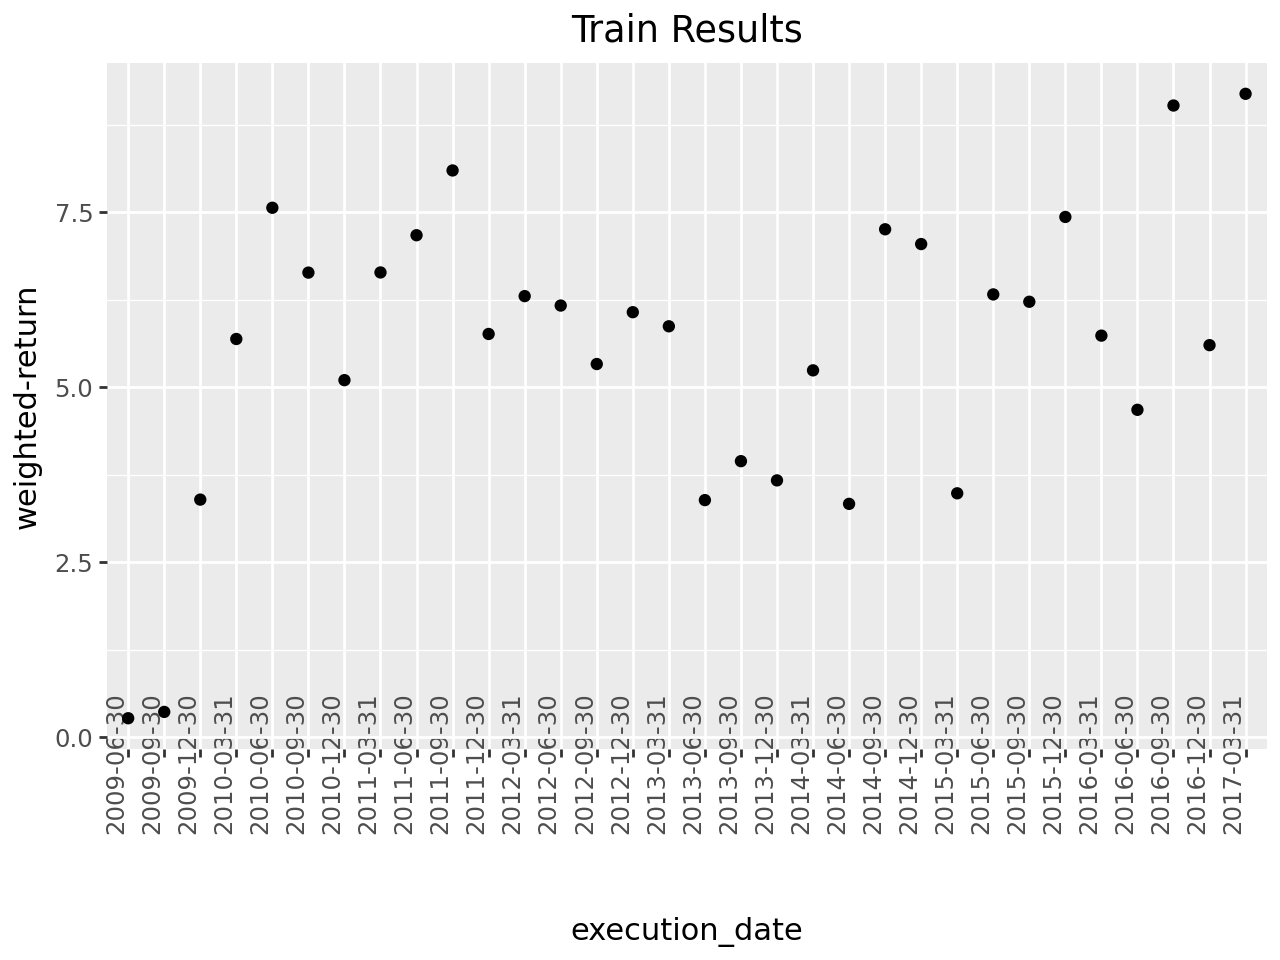

In [47]:
data_set, _ = reset_dataset_()
execution_dates = np.sort(data_set['execution_date'].unique())[8:-8]

cols_to_drop = ["OtherIncome", "OtherShareHoldersEquity"] # Null columns
 
data_set = drop_cols(data_set, cols_to_drop)


all_results = {}
all_predicted_tickers_list = []
all_models = {}
for execution_date in execution_dates[8:-8]:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, n_trees, False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)
plot_results()

Dropping columns doesn't seem to improve the model, let's see if wee fill the NaNs values. We'll use 0 as a value missing and forward fill.

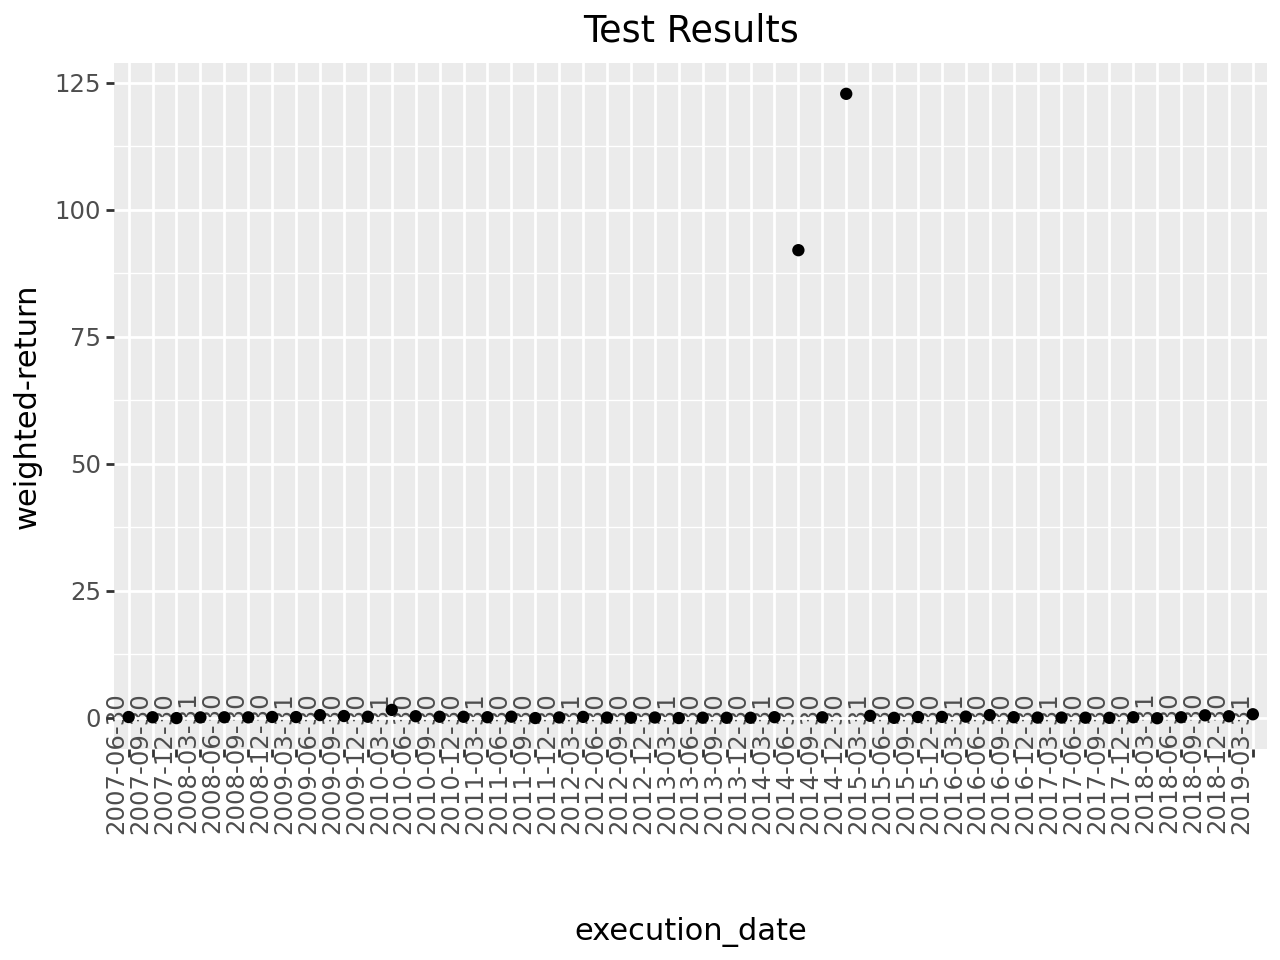

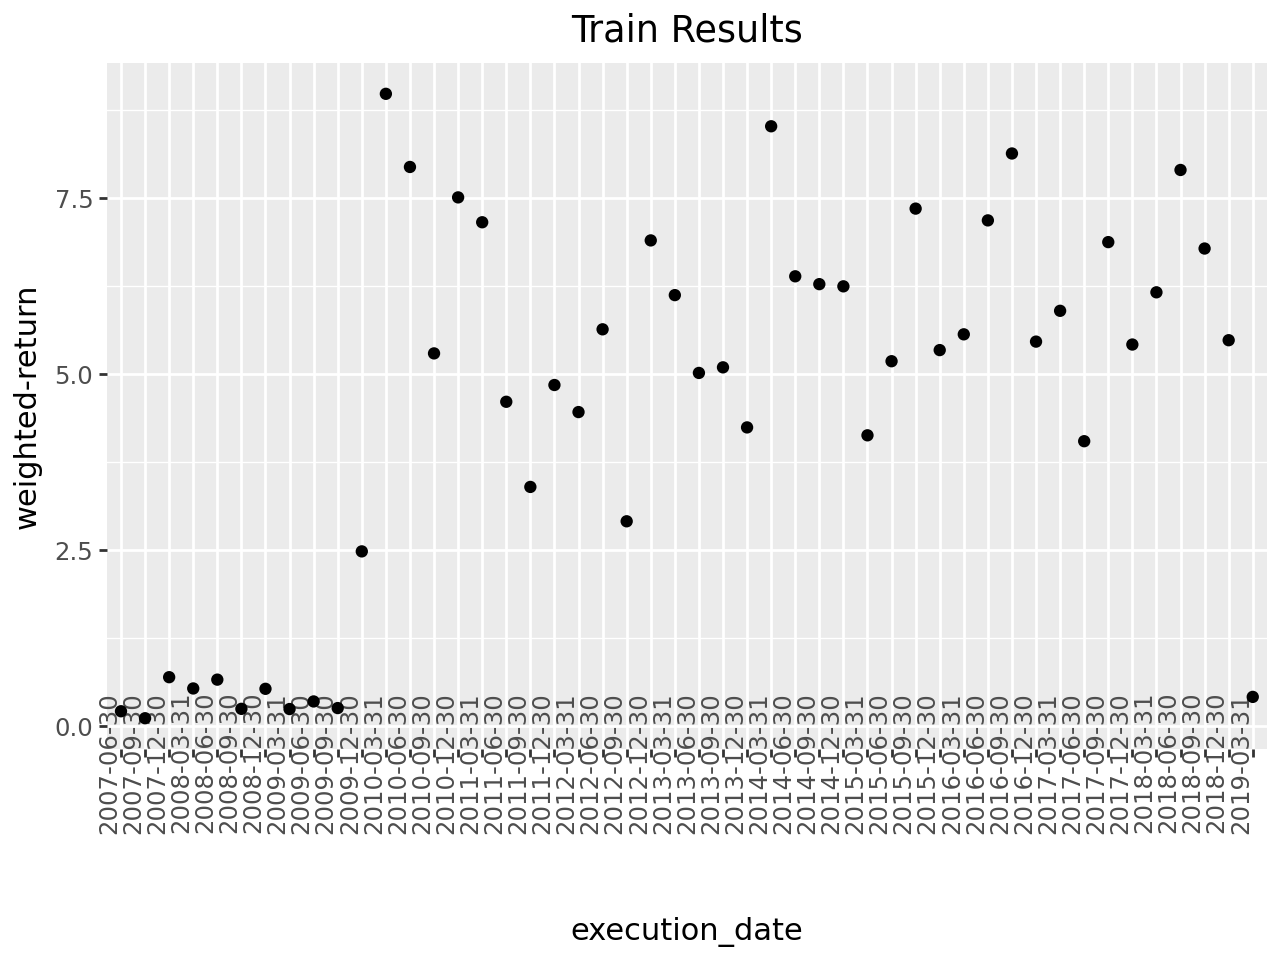

In [48]:
data_set, _ = reset_dataset_()
execution_dates = np.sort(data_set['execution_date'].unique())[8:-8]

null_columns = data_set.columns[data_set.isnull().any()].to_list()
null_columns
null_columns.remove("diff_ch_sp500")
null_columns.remove("target")
 
data_set = fill_nulls_zero(data_set, null_columns)
all_results = {}
all_predicted_tickers_list = []
all_models = {}
for execution_date in execution_dates:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, n_trees, False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)
plot_results()

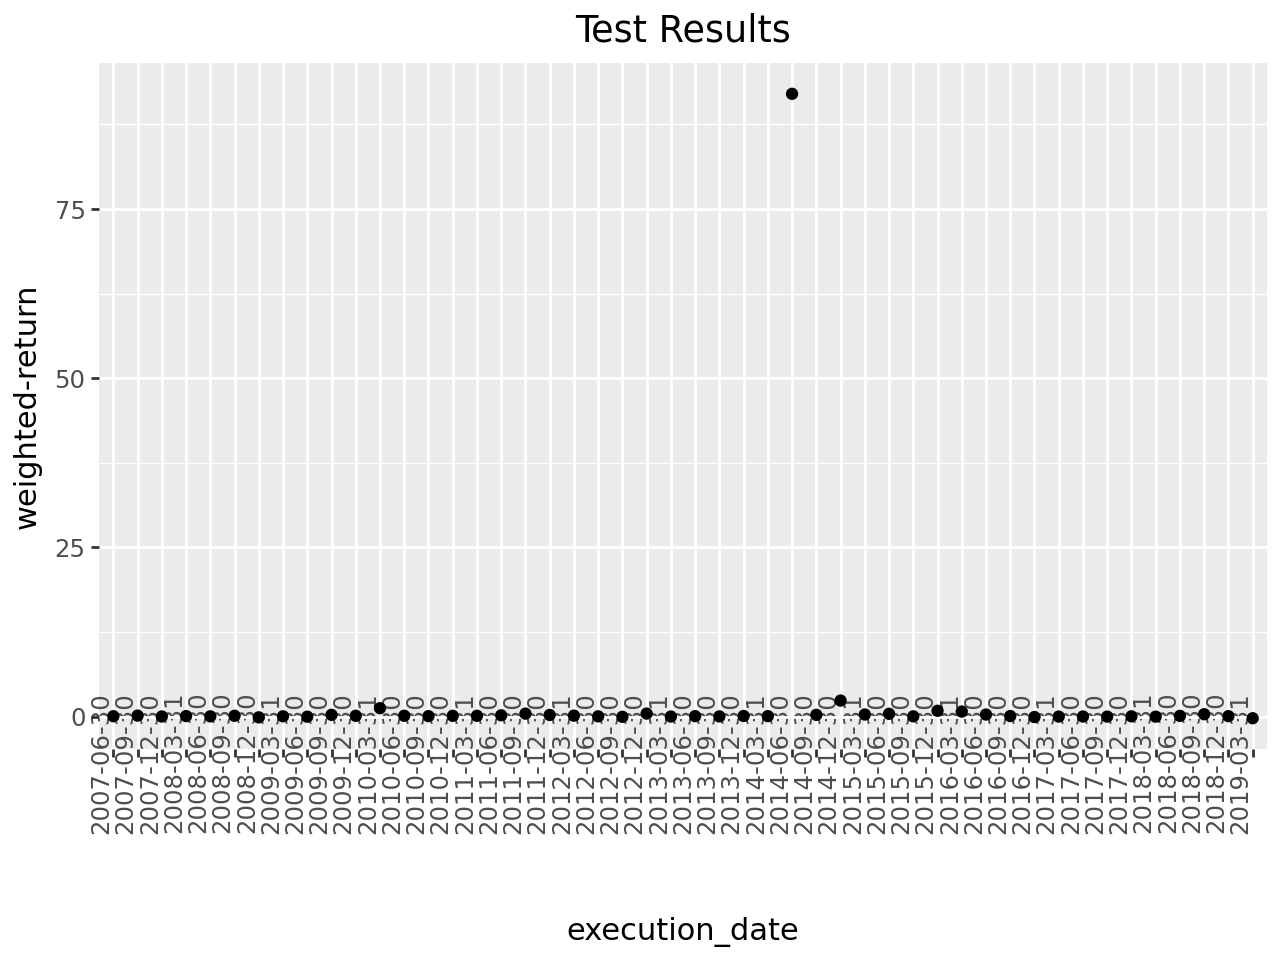

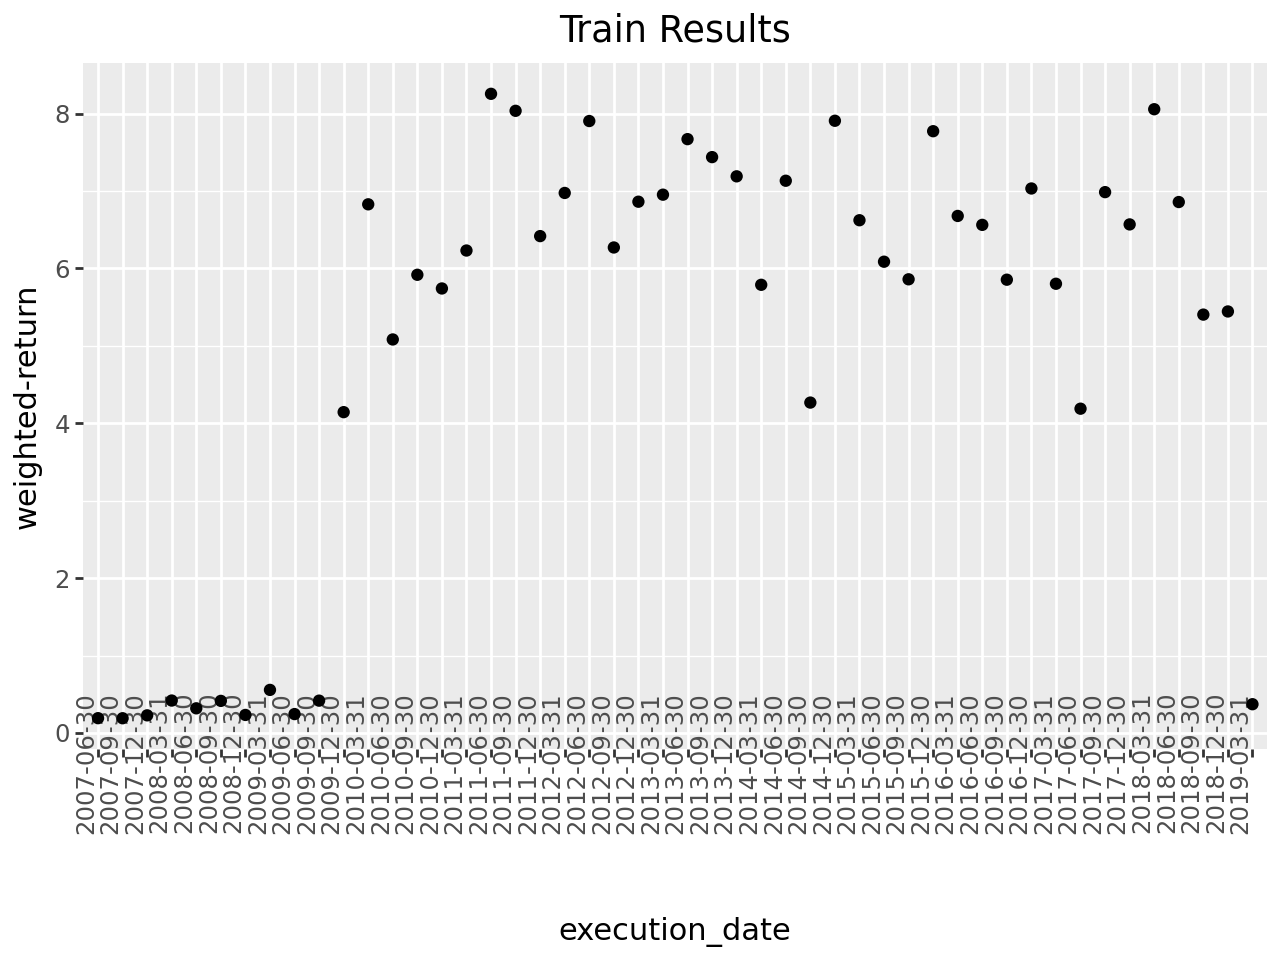

In [49]:
data_set, _ = reset_dataset_()
execution_dates = np.sort(data_set['execution_date'].unique())[8:-8]

data_set = data_set.fillna(method='ffill')
all_results = {}
all_predicted_tickers_list = []
all_models = {}
for execution_date in execution_dates:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, n_trees, False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)
plot_results()

After analyzing the data, we see that imputing missing values or reducing some correlated features doesn't improve performance at all. So we will focus on hyperparameter tuning and feature importance to see if we can find a good model that can generalize well to our data.

### Hyperparameters and feature importance

In [50]:
data_set, execution_dates = reset_dataset_()

In [51]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}
for execution_date in execution_dates:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date(execution_date, all_results, all_predicted_tickers_list, all_models, n_trees, False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

In [ ]:
len(all_results[execution_dates[9]]["training"]["binary_logloss"])

In [ ]:
all_results[execution_dates[-5]]["valid_0"]["binary_logloss"]

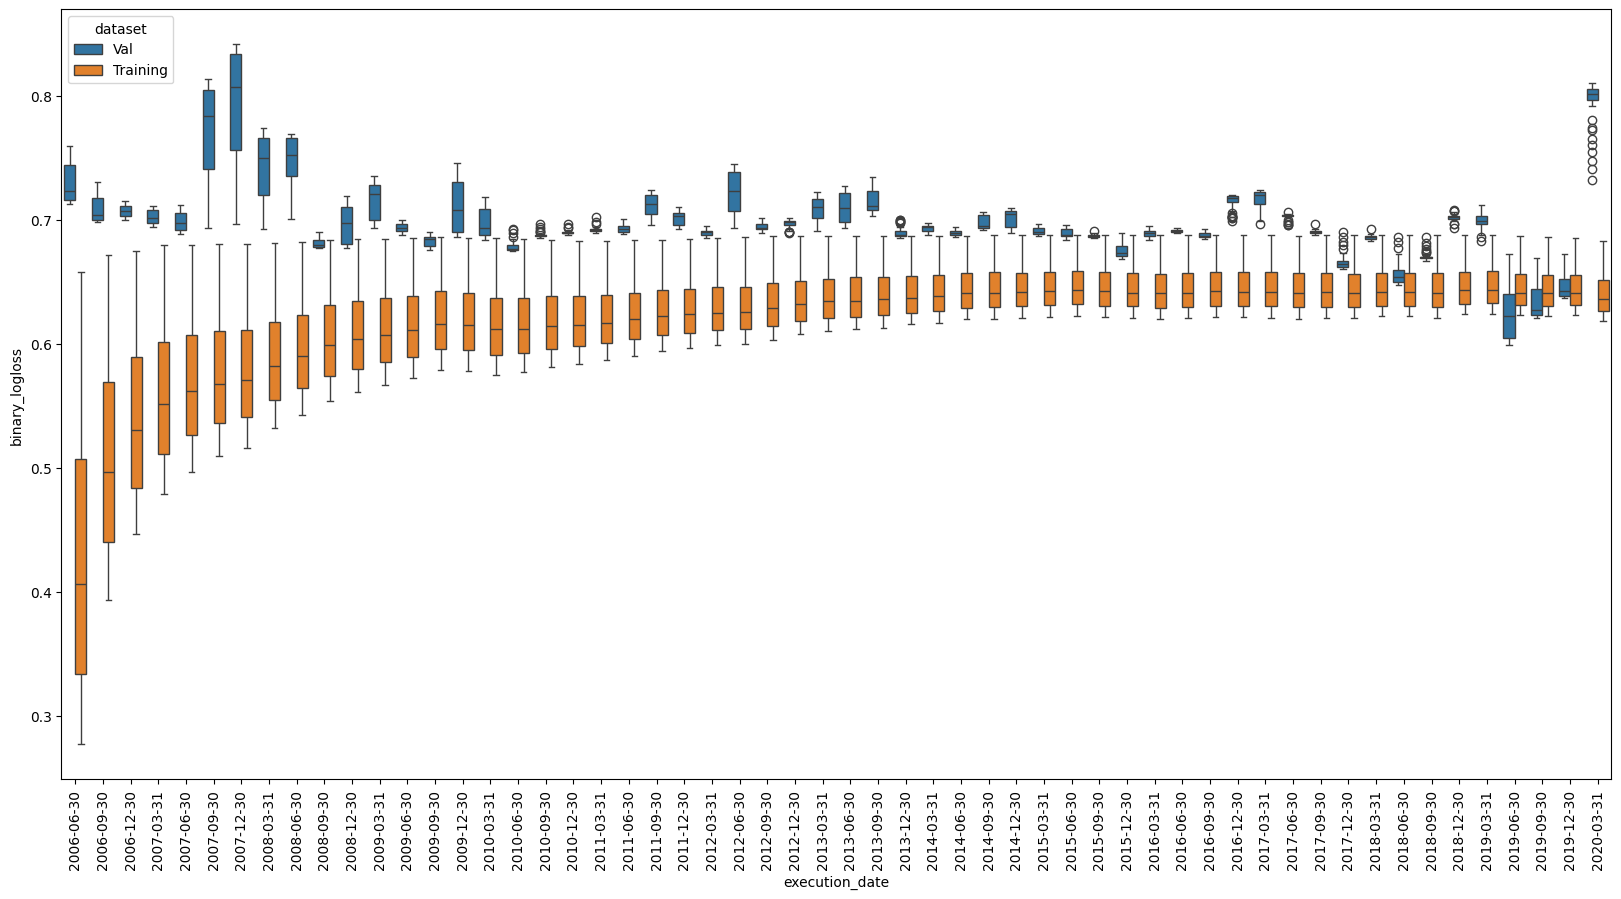

In [148]:
dates = all_results.keys()
valid_loss = []
train_loss = []
for date in dates:
    valid_loss_value = all_results[date]["valid_0"]["binary_logloss"]
    train_loss_value = all_results[date]["training"]["binary_logloss"]
    valid_loss.append(valid_loss_value)
    train_loss.append(train_loss_value)
    
valid_df = pd.DataFrame({"execution_date": dates, "binary_logloss": valid_loss})
valid_df = valid_df.explode("binary_logloss", ignore_index=True)
train_df = pd.DataFrame({"execution_date": dates, "binary_logloss": train_loss})
train_df = train_df.explode("binary_logloss", ignore_index=True)

idx_val = []
idx_train= []

for idx, row in valid_df.iterrows():
    if len(str(row['binary_logloss'])) > 30:
        idx_val.append(idx)
        
for idx, row in train_df.iterrows():
    if len(str(row['binary_logloss'])) > 30:
        idx_train.append(idx)

valid_df = valid_df.drop(idx_val)
train_df = train_df.drop(idx_train)
combined_df = pd.concat([
    valid_df.assign(dataset="Val"),
    train_df.assign(dataset="Training")
])
plt.figure(figsize=(20, 10))
sns.boxplot(x="execution_date", y="binary_logloss", data=combined_df, hue="dataset")
plt.xticks(rotation=90)
plt.show()


We can see that the training converges, but not the test set. Let's change some hyperparameters.

In [150]:
import warnings
warnings.filterwarnings('ignore')


def train_model_params(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric,
             "learning_rate": 0.001,
             }
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test

In [152]:
def run_model_for_execution_date_params(execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model_params(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test

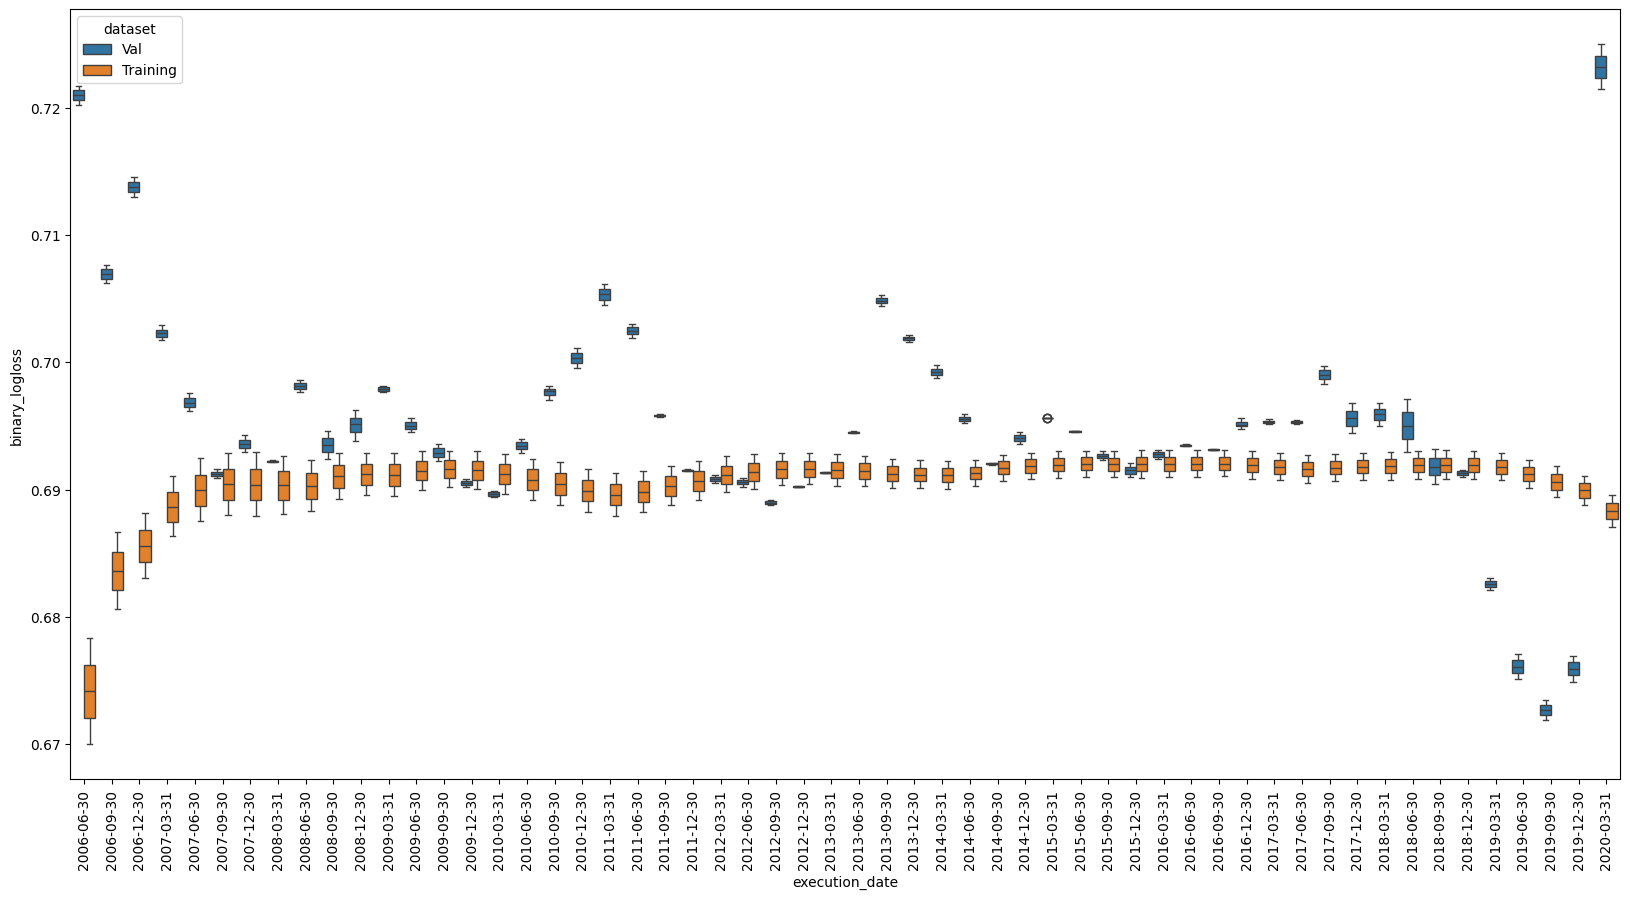

In [153]:
data_set, execution_dates = reset_dataset_()
all_results = {}
all_predicted_tickers_list = []
all_models = {}
for execution_date in execution_dates:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date_params(execution_date, all_results, all_predicted_tickers_list, all_models, n_trees, False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

dates = all_results.keys()
valid_loss = []
train_loss = []
for date in dates:
    valid_loss_value = all_results[date]["valid_0"]["binary_logloss"]
    train_loss_value = all_results[date]["training"]["binary_logloss"]
    valid_loss.append(valid_loss_value)
    train_loss.append(train_loss_value)
    
valid_df = pd.DataFrame({"execution_date": dates, "binary_logloss": valid_loss})
valid_df = valid_df.explode("binary_logloss", ignore_index=True)
train_df = pd.DataFrame({"execution_date": dates, "binary_logloss": train_loss})
train_df = train_df.explode("binary_logloss", ignore_index=True)

idx_val = []
idx_train= []

for idx, row in valid_df.iterrows():
    if len(str(row['binary_logloss'])) > 30:
        idx_val.append(idx)
        
for idx, row in train_df.iterrows():
    if len(str(row['binary_logloss'])) > 30:
        idx_train.append(idx)

valid_df = valid_df.drop(idx_val)
train_df = train_df.drop(idx_train)
combined_df = pd.concat([
    valid_df.assign(dataset="Val"),
    train_df.assign(dataset="Training")
])
plt.figure(figsize=(20, 10))
sns.boxplot(x="execution_date", y="binary_logloss", data=combined_df, hue="dataset")
plt.xticks(rotation=90)
plt.show()


Test set still not learning, let's see feature importance.

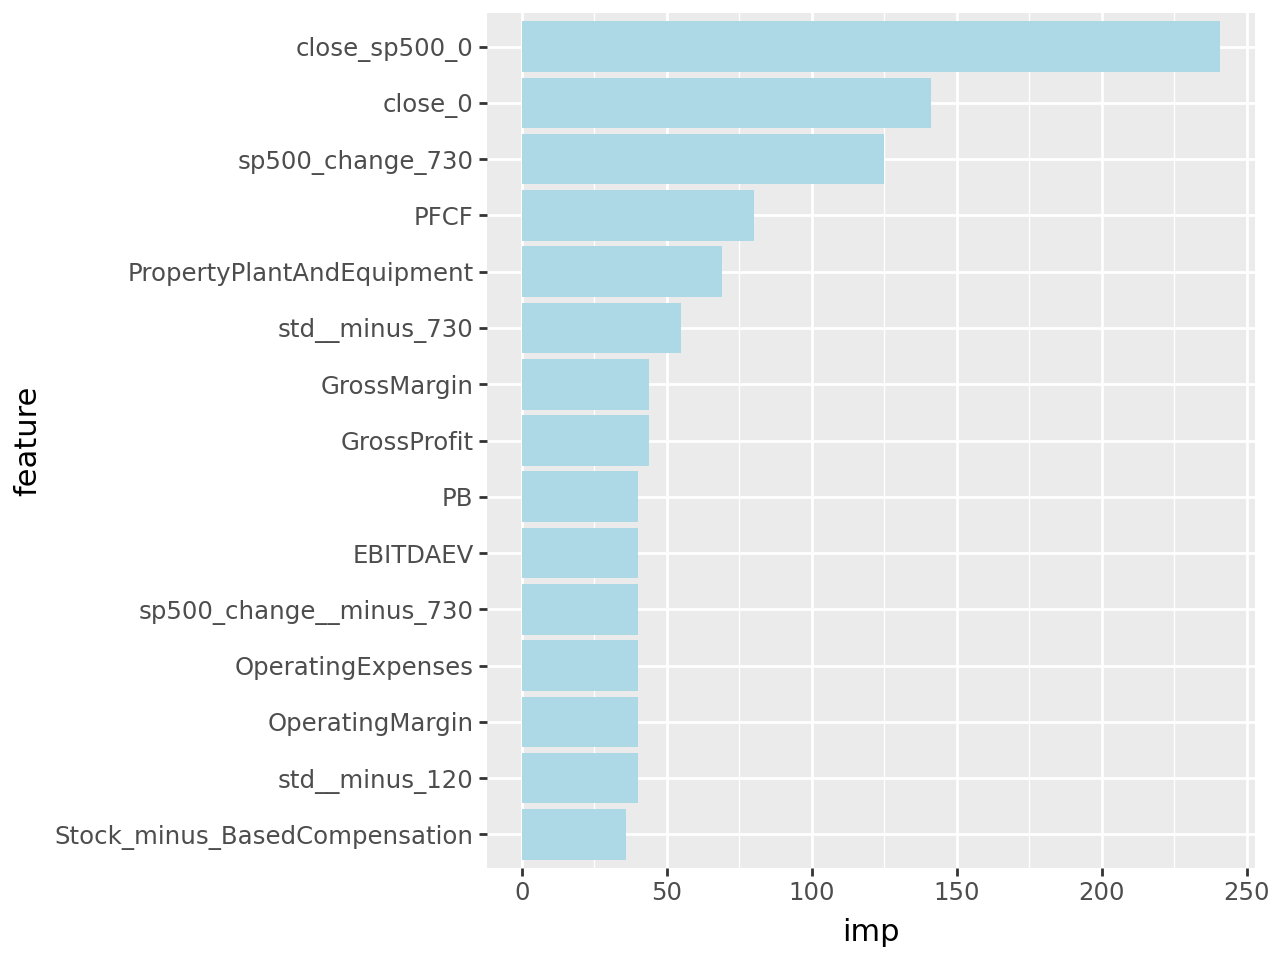

In [178]:
dates = list(all_models.keys())

model = all_models[dates[-1]]

draw_feature_importance(model, top = 15)

We see that technical features have a lot of importance, let's try dropping them in case they are producing some kind of data leakage.

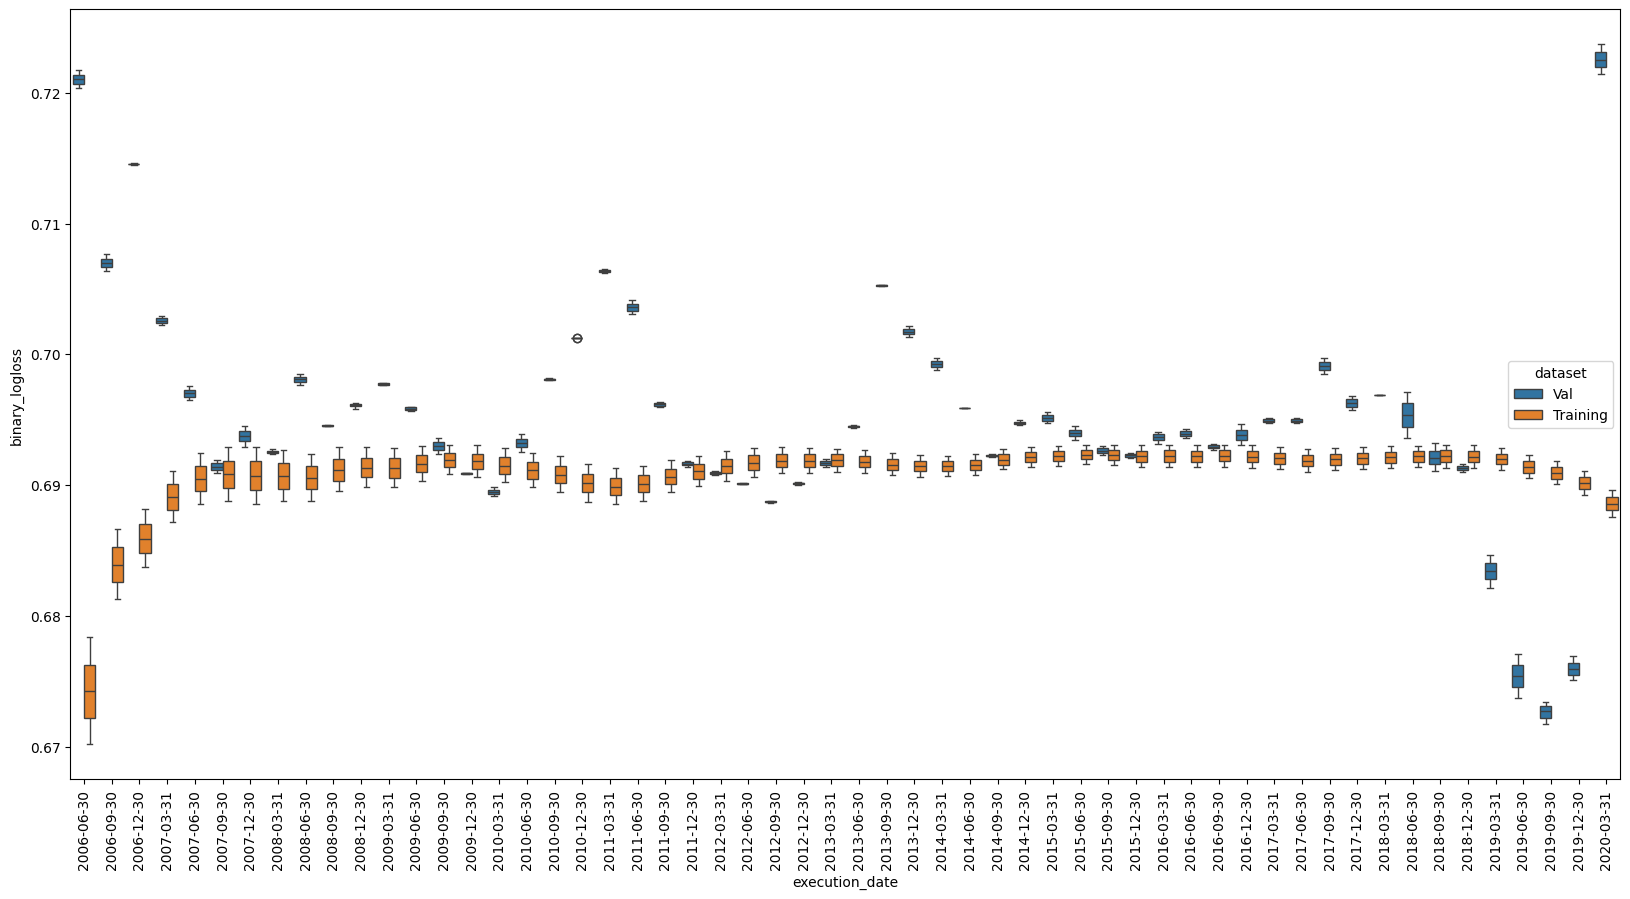

In [180]:
data_set, execution_dates = reset_dataset_()

data_set.drop(technical_features, axis=1, inplace=True, errors='ignore')
all_results = {}
all_predicted_tickers_list = []
all_models = {}
for execution_date in execution_dates:
    all_results, all_predicted_tickers_list, all_models, model, X_train, X_test = run_model_for_execution_date_params(execution_date, all_results, all_predicted_tickers_list, all_models, n_trees, False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

dates = all_results.keys()
valid_loss = []
train_loss = []
for date in dates:
    valid_loss_value = all_results[date]["valid_0"]["binary_logloss"]
    train_loss_value = all_results[date]["training"]["binary_logloss"]
    valid_loss.append(valid_loss_value)
    train_loss.append(train_loss_value)
    
valid_df = pd.DataFrame({"execution_date": dates, "binary_logloss": valid_loss})
valid_df = valid_df.explode("binary_logloss", ignore_index=True)
train_df = pd.DataFrame({"execution_date": dates, "binary_logloss": train_loss})
train_df = train_df.explode("binary_logloss", ignore_index=True)

idx_val = []
idx_train= []

for idx, row in valid_df.iterrows():
    if len(str(row['binary_logloss'])) > 30:
        idx_val.append(idx)
        
for idx, row in train_df.iterrows():
    if len(str(row['binary_logloss'])) > 30:
        idx_train.append(idx)

valid_df = valid_df.drop(idx_val)
train_df = train_df.drop(idx_train)
combined_df = pd.concat([
    valid_df.assign(dataset="Val"),
    train_df.assign(dataset="Training")
])
plt.figure(figsize=(20, 10))
sns.boxplot(x="execution_date", y="binary_logloss", data=combined_df, hue="dataset")
plt.xticks(rotation=90)
plt.show()

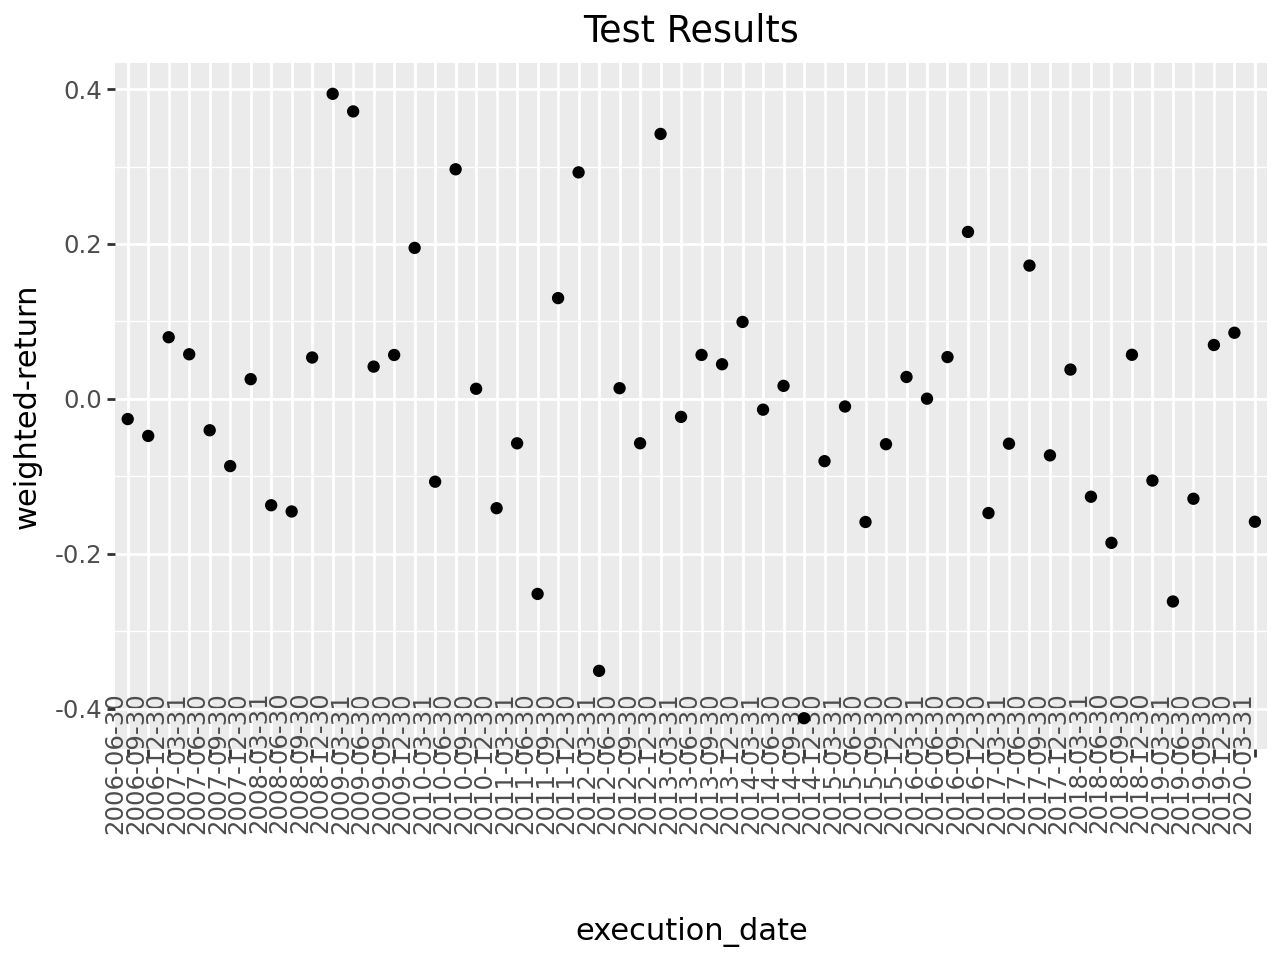

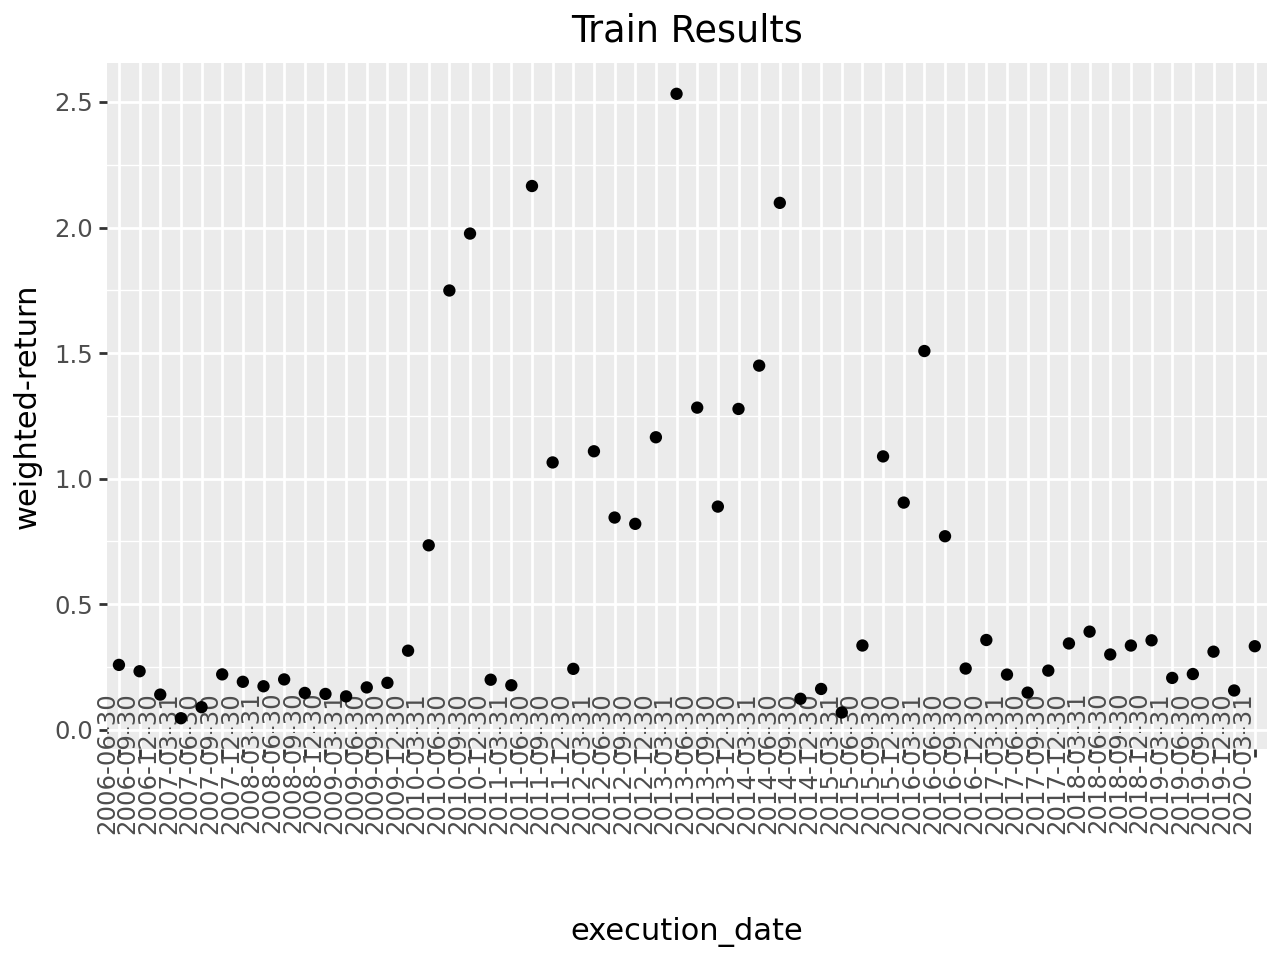

In [181]:
plot_results()

In [203]:
dates = list(all_results.keys())

wt = []

for date in dates:
    wt.append(np.mean(all_results[date]["valid_0"]["weighted-return"]))

np.mean(wt)

0.07620657835009312

After removing the technical features, we get better results for the test set (earlier we only got returns for 4 execution dates).

We can see that in this case sometimes we have losses (negatives weighted returns) but overall, the sum of all of them yields a positive weighted-return